In [178]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from mlxtend.regressor import StackingRegressor

In [179]:
# house_price : Regresi

df = pd.read_csv("house_price.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Preparation

In [180]:
df.shape

(1460, 81)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [182]:
df.SaleCondition.value_counts() 

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

In [183]:
df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [184]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [185]:
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
301,302,60,RL,66.0,16226,Pave,NaN,IR3,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,267000


## EDA

In [186]:
categorical_cols = df.dtypes[(df.dtypes == "object") | (df.dtypes == "string")].index
categorical_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [187]:
categorical_cols = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_cols))

numerical_cols = df.describe()
print("Number of Numerical features: ", len(numerical_cols))

Number of Categorical features:  43
Number of Numerical features:  8


## Categorical Analysis

### Structure of Land and Property

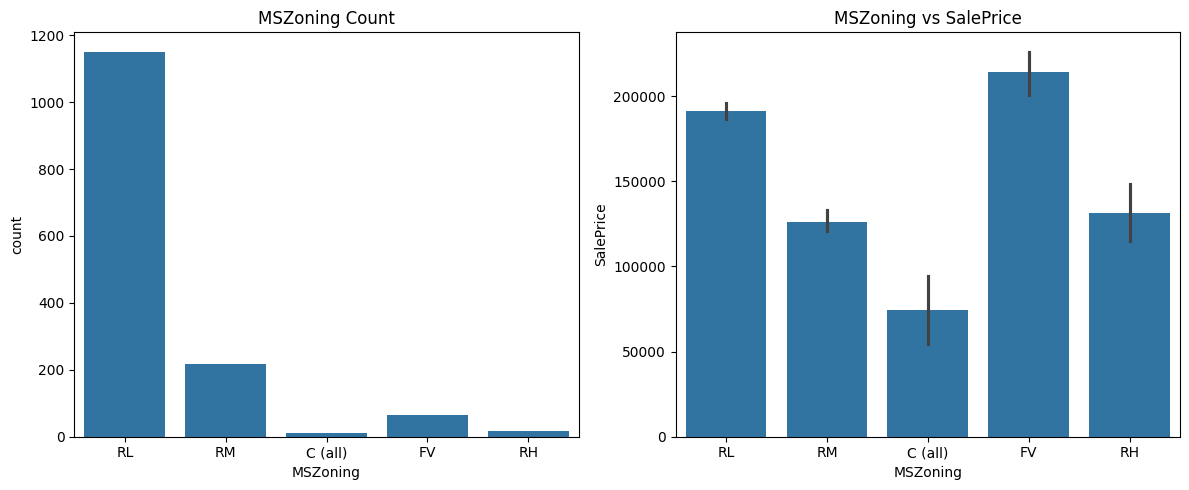

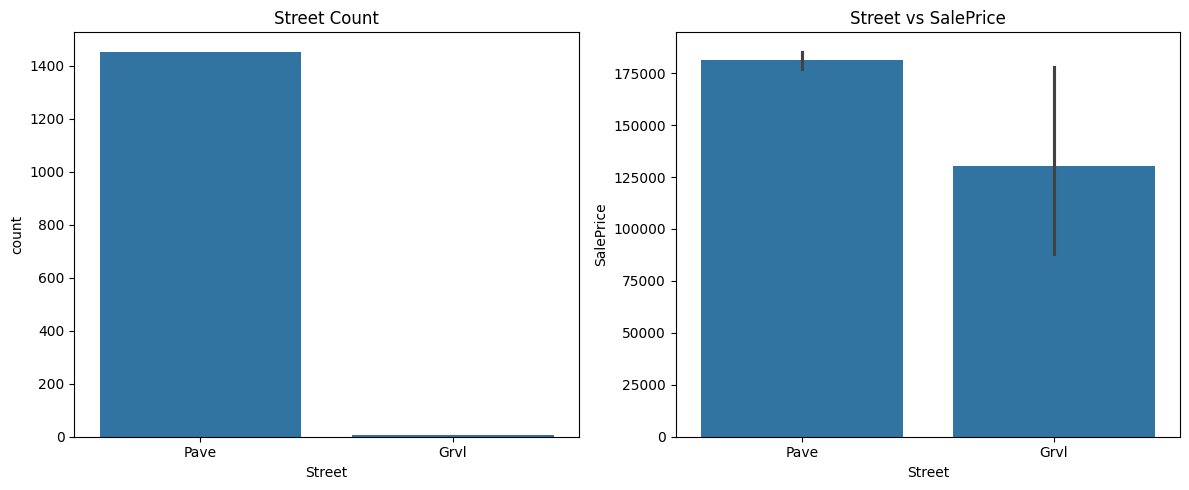

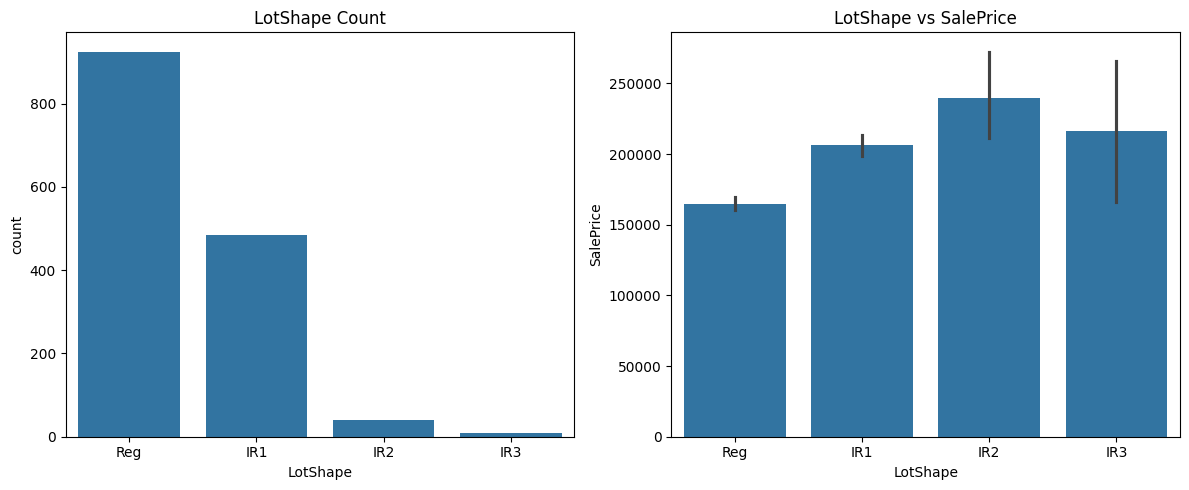

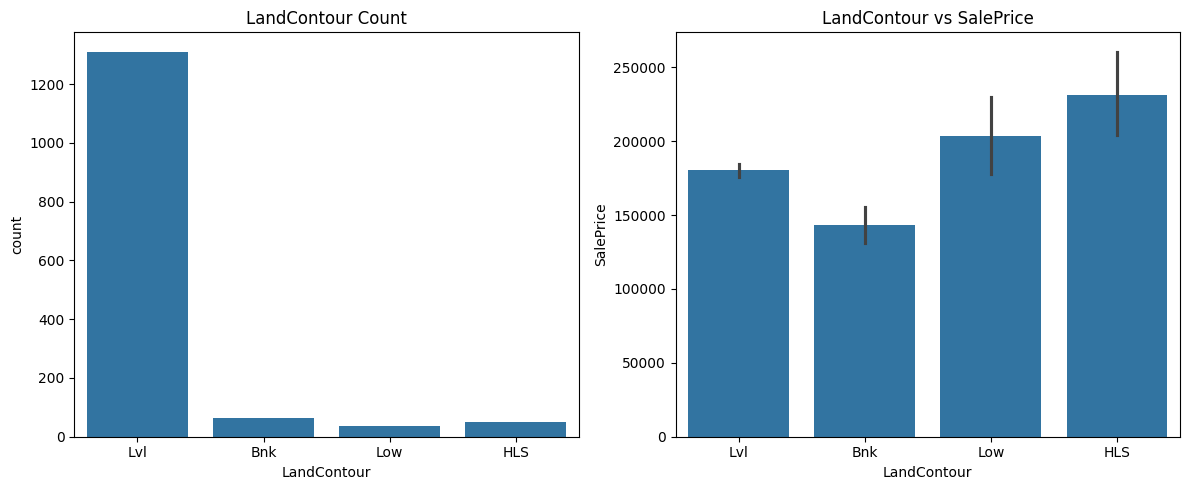

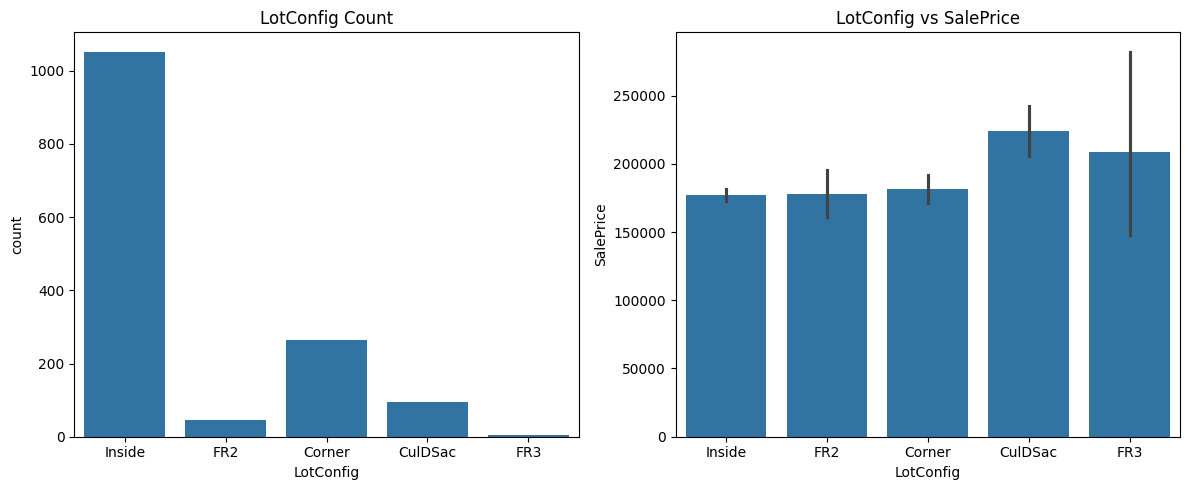

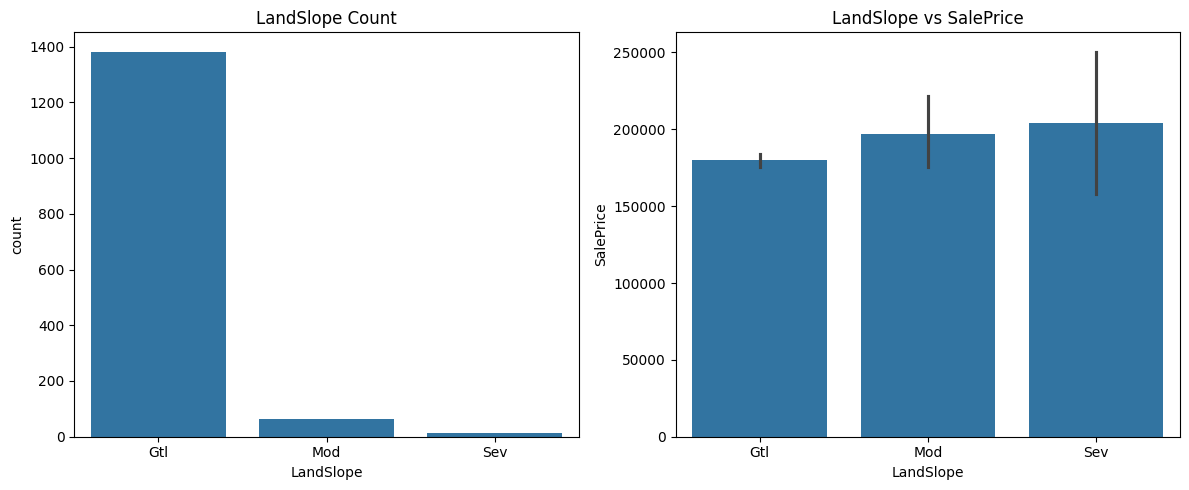

In [188]:
cat_cols_land = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope']

for feature in cat_cols_land:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')

    plt.tight_layout()
    
    plt.show()

MSZoning:
- The Residential Low Density (RL) zone has a large number of around 1000 and above. Meanwhile, the smallest number is in the commercial zone. When compared with the selling price, the Floating Village (FV) zone has a higher selling price of around 200,000. Meanwhile the Commercial zone has the lowest selling price.

Land Contour:
- Houses with the highest land contours are level or flat, while there are only a few types of land contours such as cliffs or slopes (BNK), low, hills (HLS). When compared with the selling price, houses that have a significant slope on both sides (HLS) or are almost flat (Low), the selling price is higher. For Stressed and Turned slopes, Selling Prices decrease.

Road :
- The number of asphalt roads is much greater than the number of gravel roads. Next, compare it with the selling price. For paved road access prices are higher and most houses with gravel roads have low prices.

LotShape :
- The type of house with a regular shape has the largest number. But it can be seen that houses with regular shapes have cheap prices. And as irregularity increases, the average selling price of these homes also increases.

LotConfig :
- The number of houses located within the block (not on the corner or on the side of the road) has the largest number. Meanwhile, the plot configuration does not seem to change the price significantly. Properties with Cul de Sac (street or alley closed at one end) and FR3 (Frontage on 3 sides of the property) configurations average higher scores than other configurations.

Land Slope:
- The number of houses that have a gentle slope is greater. However, when compared to the selling price, most properties have a gentle slope and are the cheapest, while properties with a moderate or heavy slope have a higher value.

Conclusion : Residential Low Density (RL) zones are the main choice with the largest number of properties, while commercial zones have fewer properties. In terms of selling prices, Floating Village (FV) zones stand out with the highest values, while commercial zones tend to have lower selling prices. Flat or level land contours dominate, but properties with a significant slope or almost flat have a higher selling price. Paved road access is more common and correlates with higher selling prices compared to gravel roads. Properties with regular landforms and Cul de Sac and FR3 configurations tend to have higher values. In addition, moderate or heavy slopes of land tend to provide higher value, while sloping land tends to have a lower selling price.

### Location and Style

In [189]:
table = df.groupby(['Neighborhood'],as_index=False)['SalePrice'].median()
table = table.sort_values(by='SalePrice',ascending=False)
table.style.background_gradient(cmap='Reds')

,Neighborhood,SalePrice
16,NridgHt,315000.000000
15,NoRidge,301500.000000
22,StoneBr,278000.000000
23,Timber,228475.000000
21,Somerst,225500.000000
24,Veenker,218000.000000
6,Crawfor,200624.000000
4,ClearCr,200250.000000
5,CollgCr,197200.000000
0,Blmngtn,191000.000000


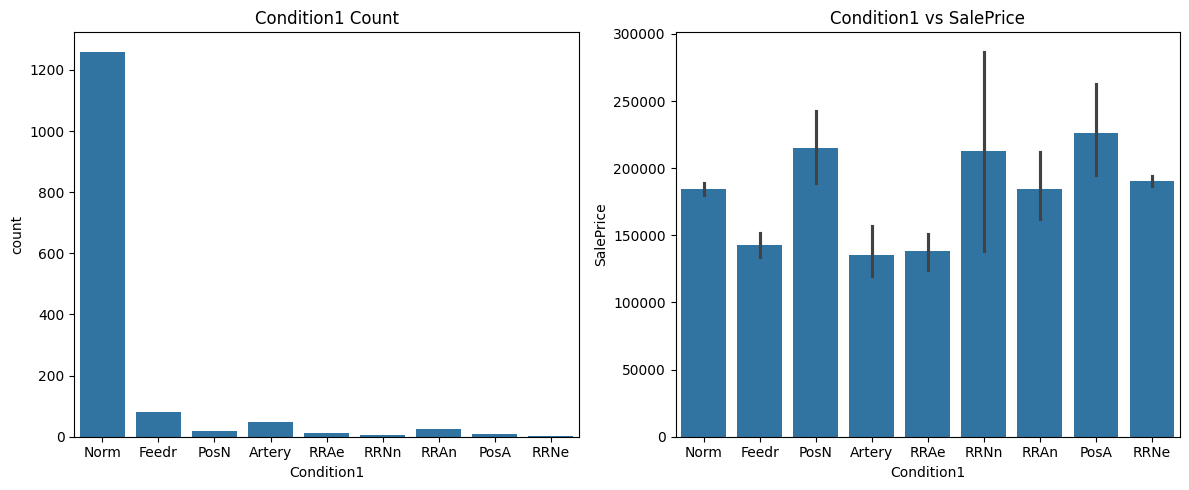

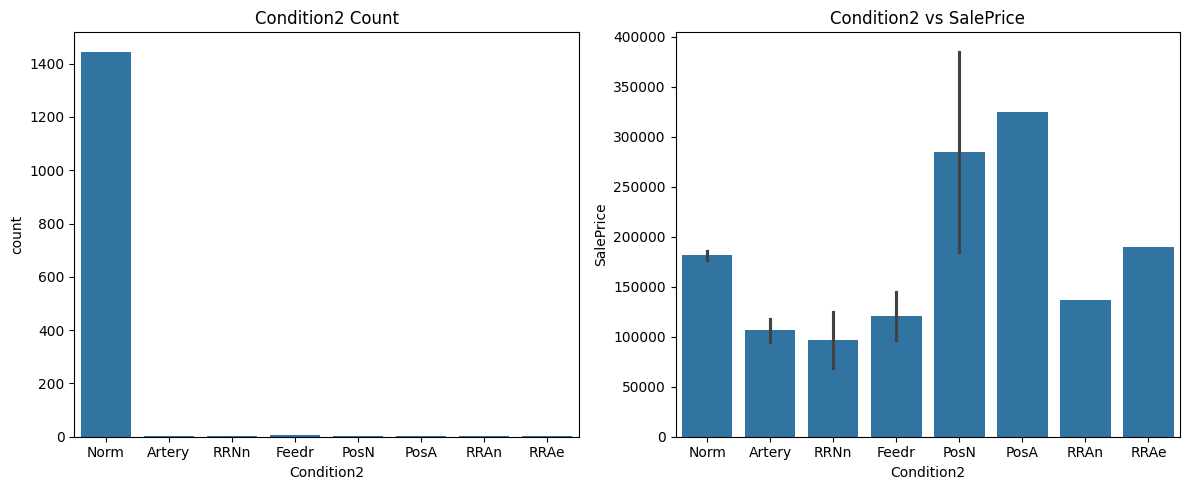

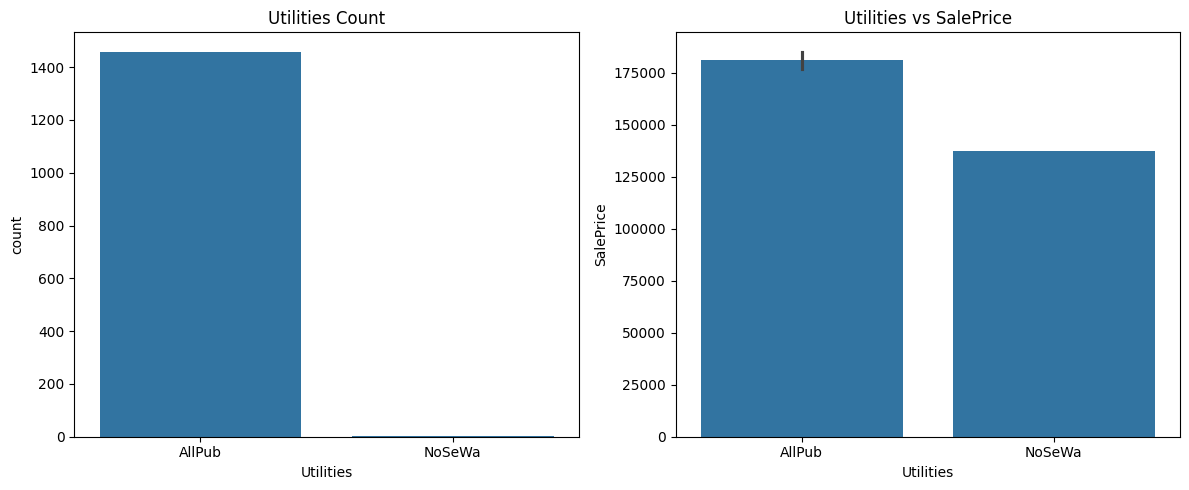

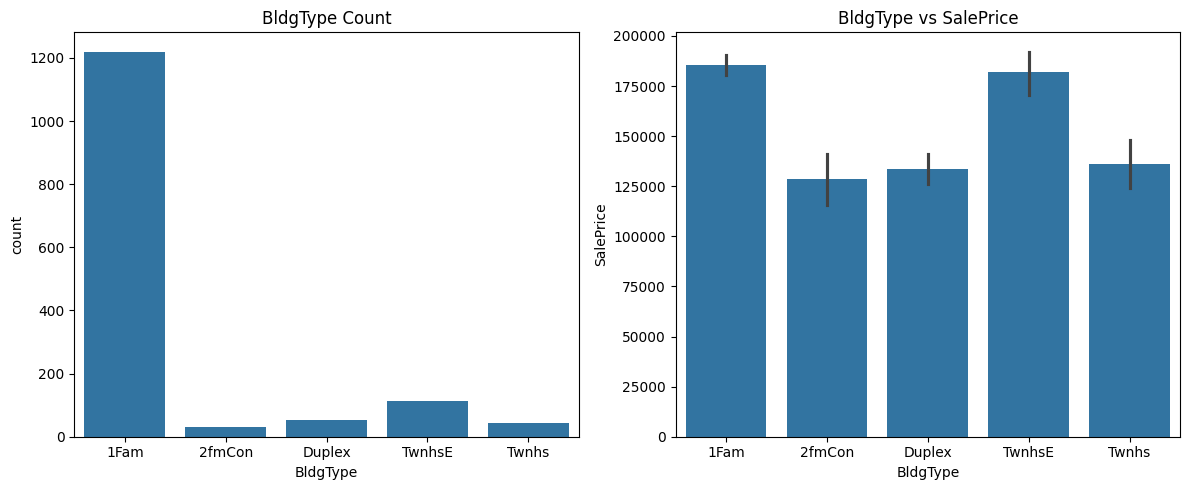

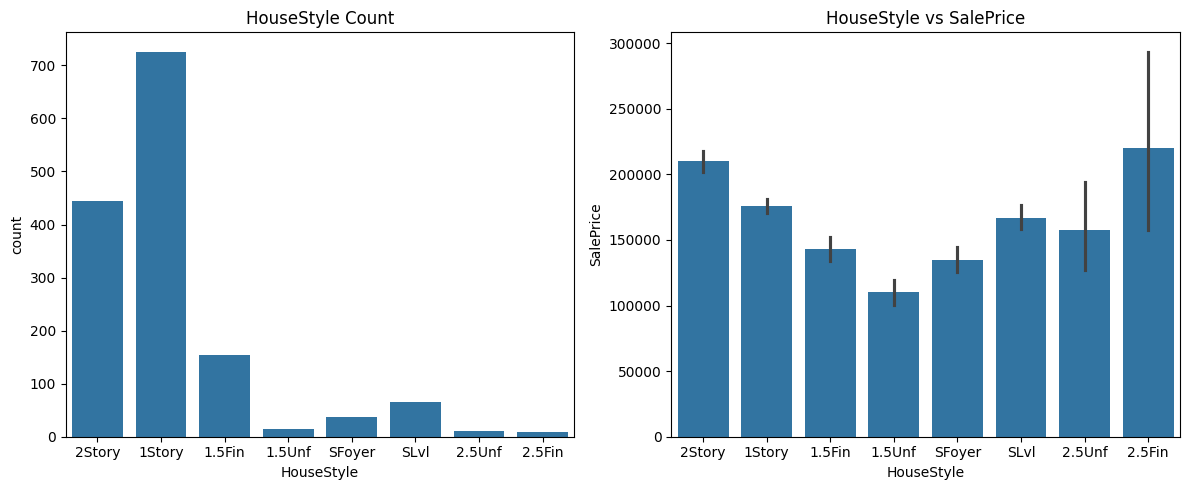

In [190]:
cat_cols_land_2= ['Condition1', 'Condition2','Utilities','BldgType', 'HouseStyle']

for feature in cat_cols_land_2:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')

    plt.tight_layout()
    
    plt.show()

Conditions 1 and 2:
- In Conditions 1 and 2 under normal circumstances there are the most interest, but when compared with the selling price, proximity to conditions such as highways reduces the selling price and with railways, the price becomes high.

Building Type:
- Single-family detached residences have a lot of interest and these residences have higher selling prices than duplexes, two-family houses, and townhouse residences

House Style:
- The 1-storey house style has the highest number, when compared with the selling price, so 2-storey and 1-storey houses have the highest selling price than unfinished properties.


Conclusion: In Conditions 1 and 2, properties with normal conditions have the highest interest, however, proximity to the main road has the effect of reducing the selling price, while proximity to the railway increases the selling price. Building type also plays a role, with single-family detached residences being a top choice with high interest and higher selling prices compared to other types such as duplexes, two-family homes and townhouses. The 1-story house style dominates by the largest number, and when compared with selling prices, 1-story and 2-story houses have the highest selling prices compared to unfinished properties.

### Roofing,Foundation and housing exterior

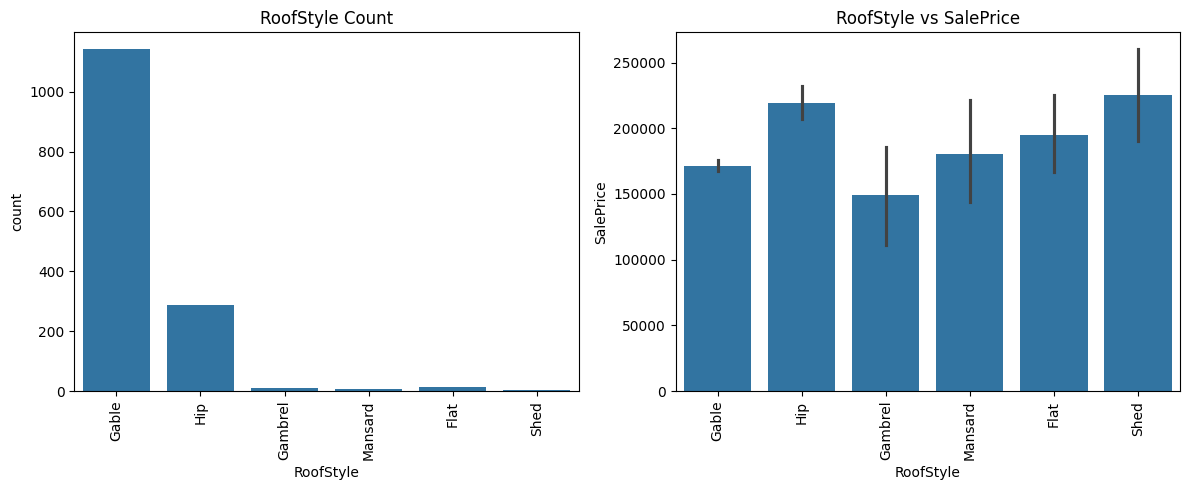

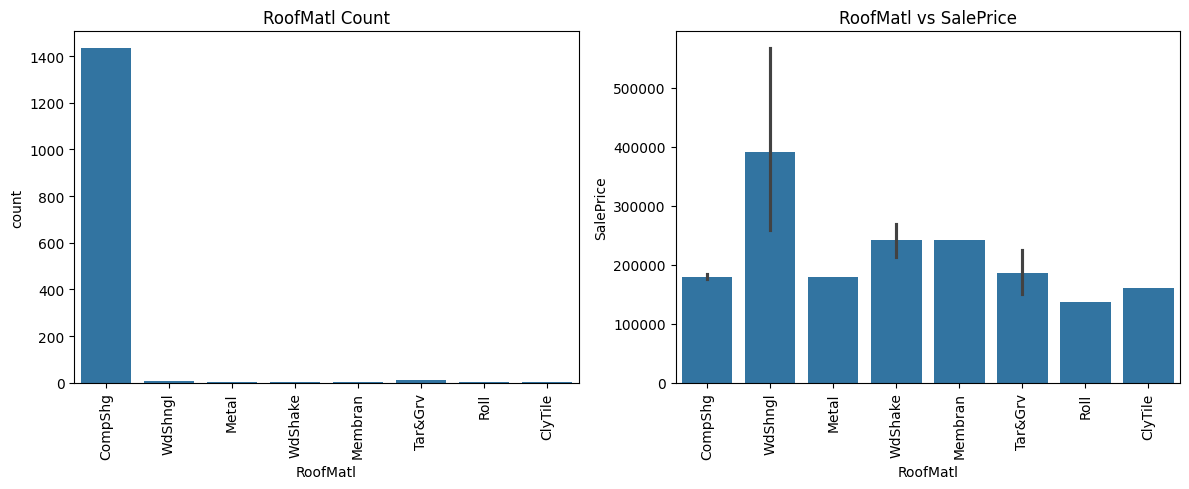

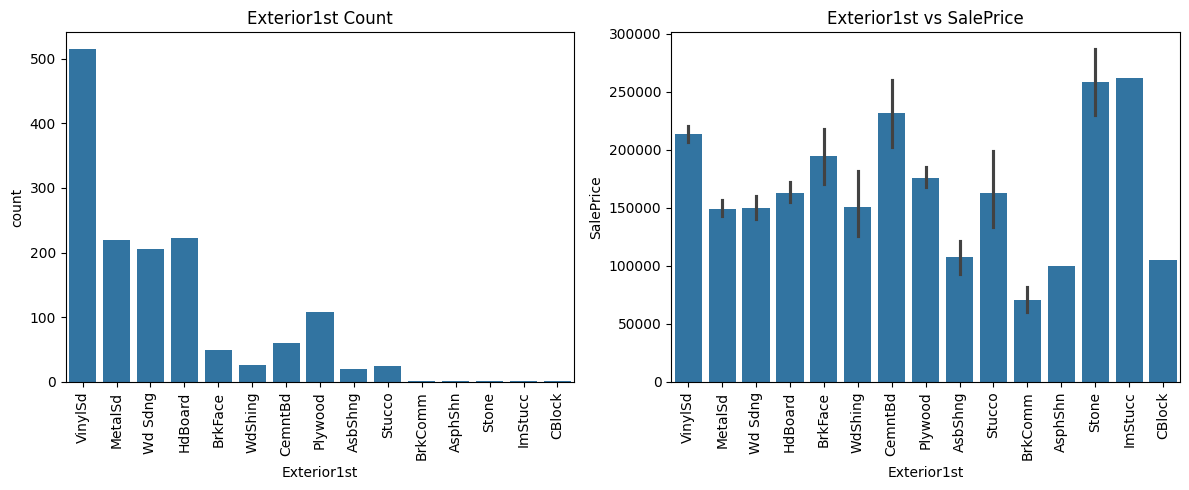

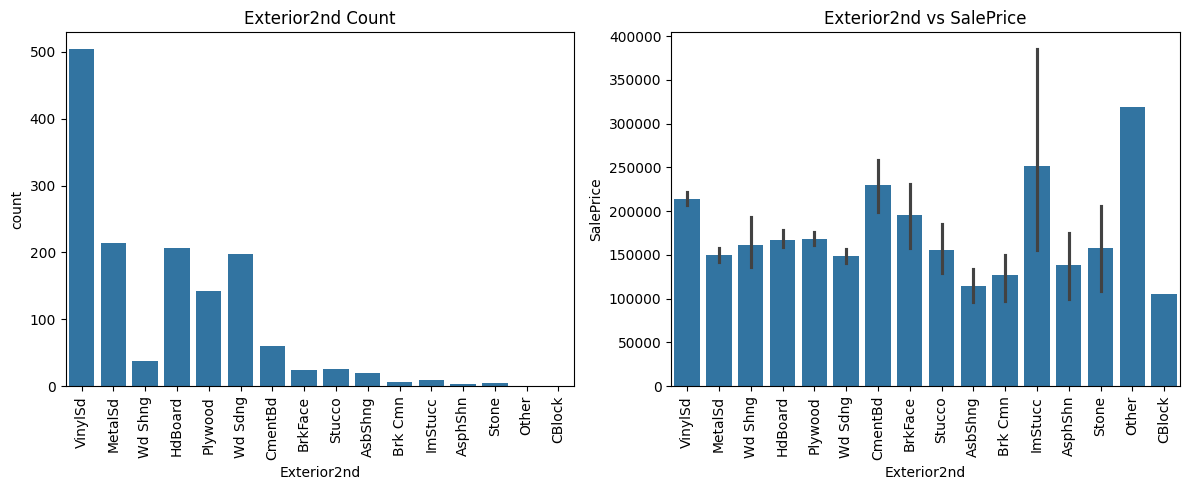

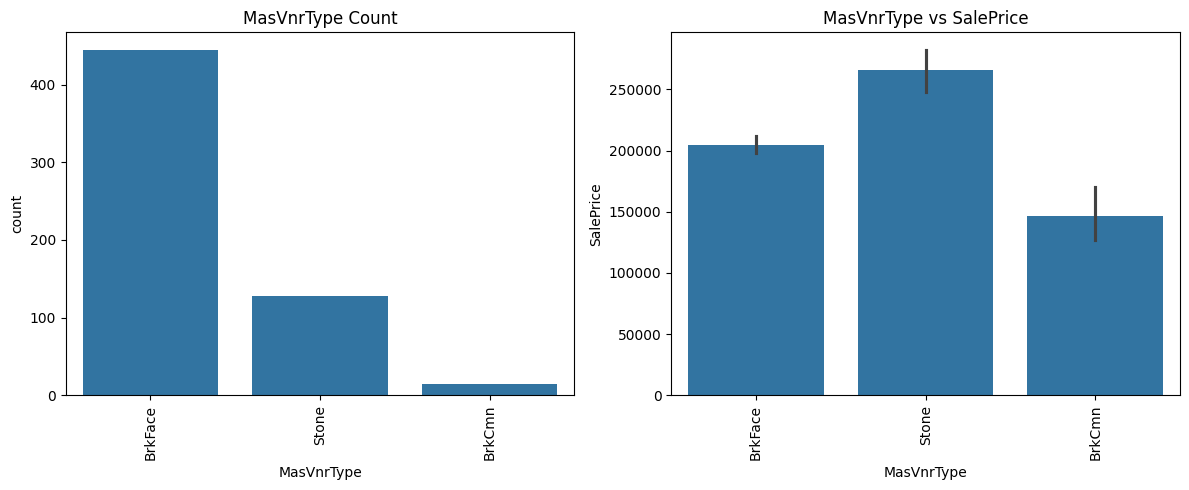

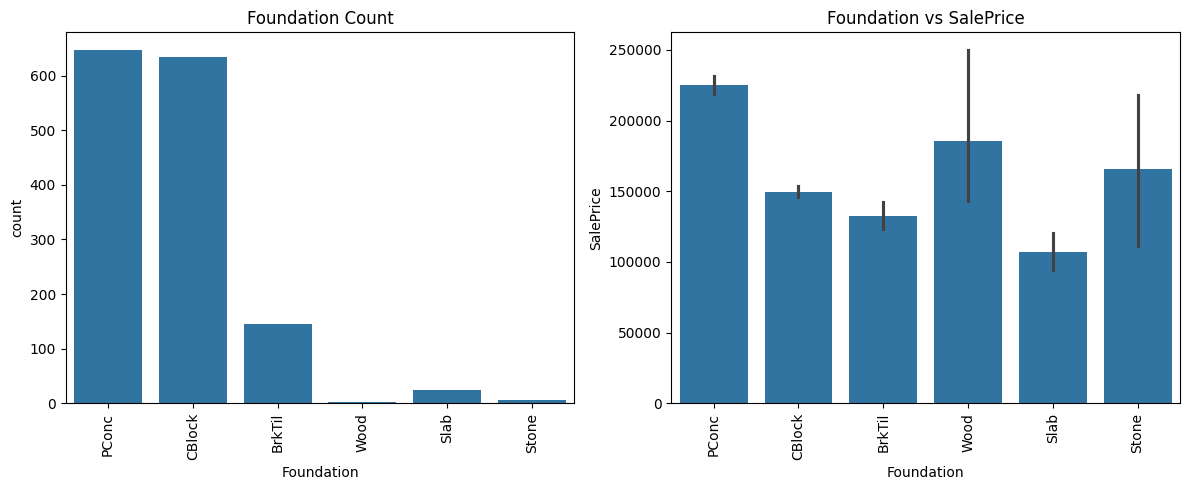

In [191]:
cat_cols_land_3 = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation']

for feature in cat_cols_land_3:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()


Exteriors 1 and 2 with Vinyl Coating have the largest number, you can see the difference in selling prices for the exterior covering of the house.
Plaster, Stone, Imitation Cement Board coverings have a high value in determining the selling price, while the lowest value is for ordinary brick coverings.
2nd Exterior: - Having a lot of materials changes the price of the house. The value of stone is down while Cement board and Vinyl Siding are about the same price.

Roof Style: The gable roof type is the most common type of house roof style. Most homes have gable and hip roof styles and the average selling price is 150000. The highest average selling price is for properties that have a shed roof model and the lowest selling price.

### Exterior Condition and Quality

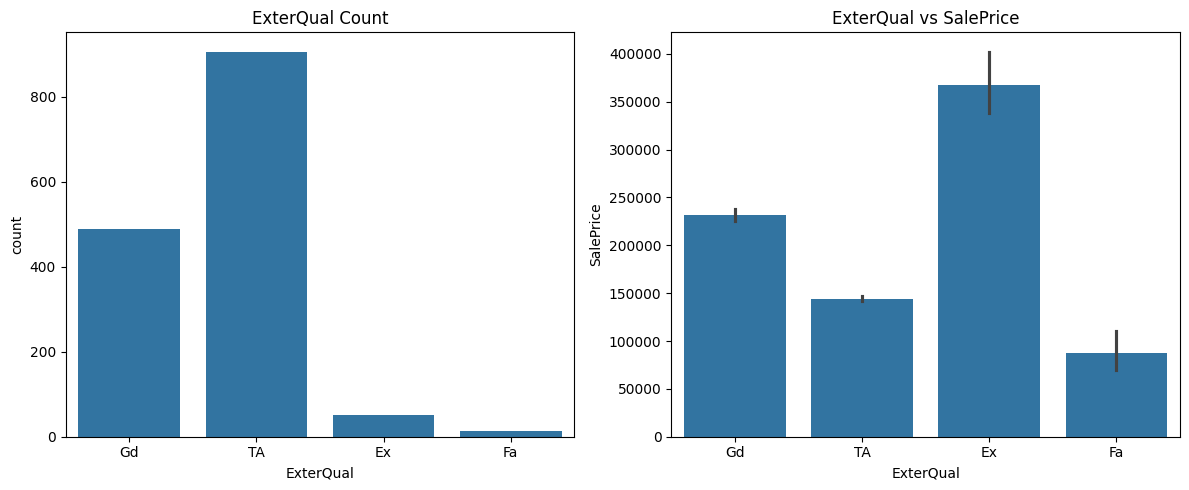

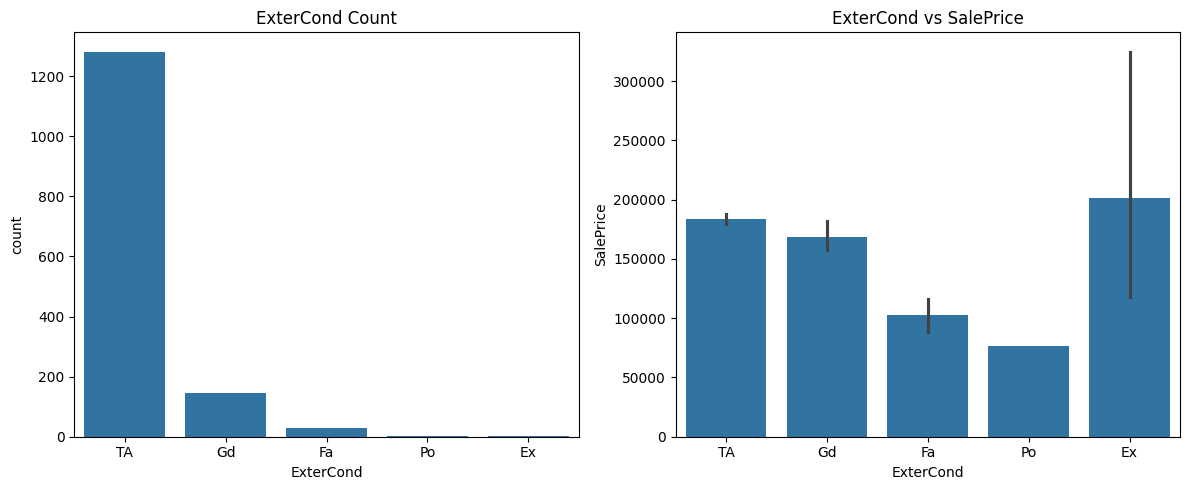

In [192]:
cat_cols_land_4 = ['ExterQual', 'ExterCond']

for feature in cat_cols_land_4:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    # axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    # axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Exterior Quality:
- If the exterior quality is good or excellent, the price will be more expensive. Most properties have average exterior quality and very few have excellent exterior quality.

Exterior Condition:
- Properties with average, good and excellent exterior conditions will have a higher selling price. And here also most of the properties have average exterior condition and only 3 properties in the data set have excellent exterior condition.

### Basements

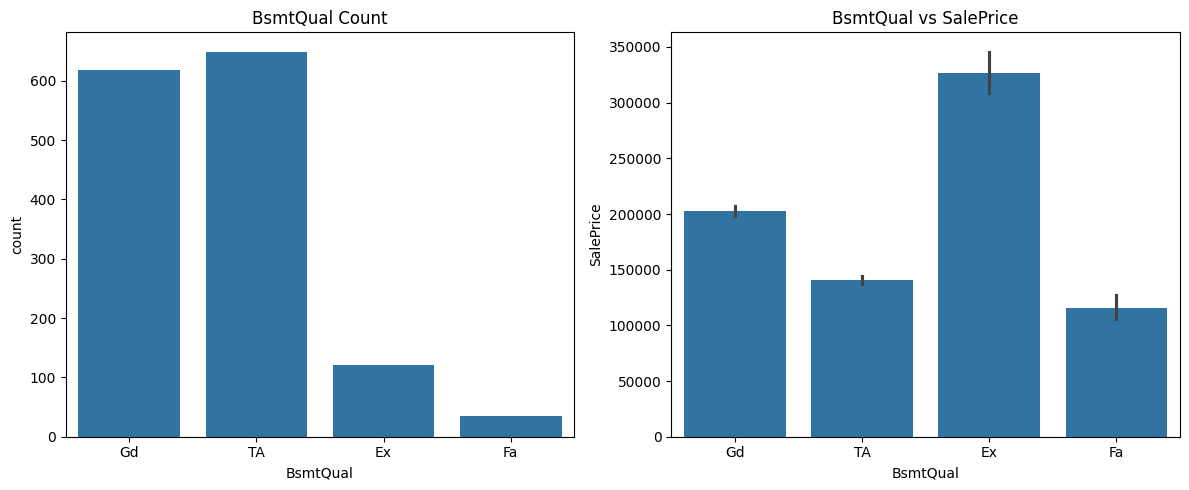

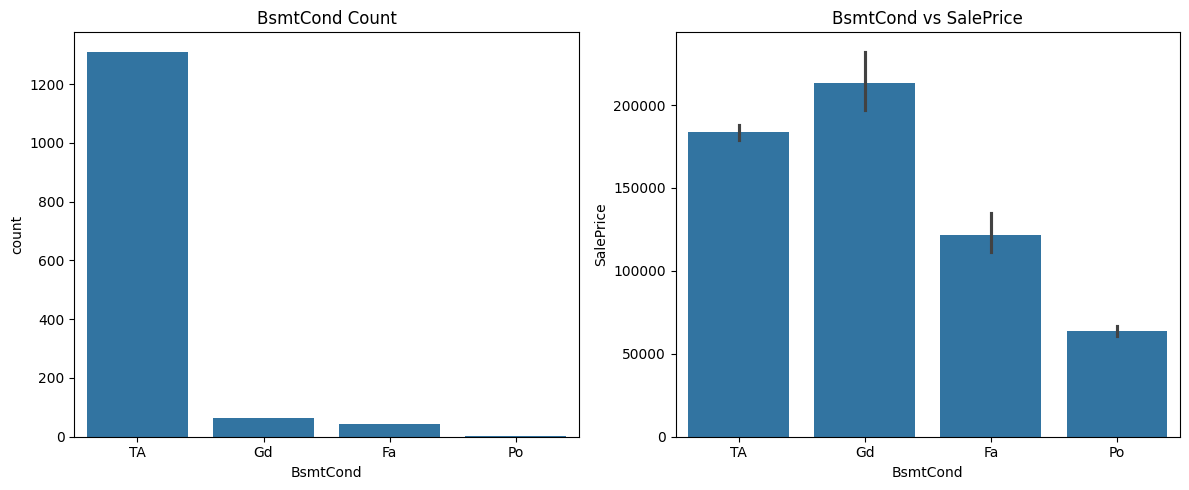

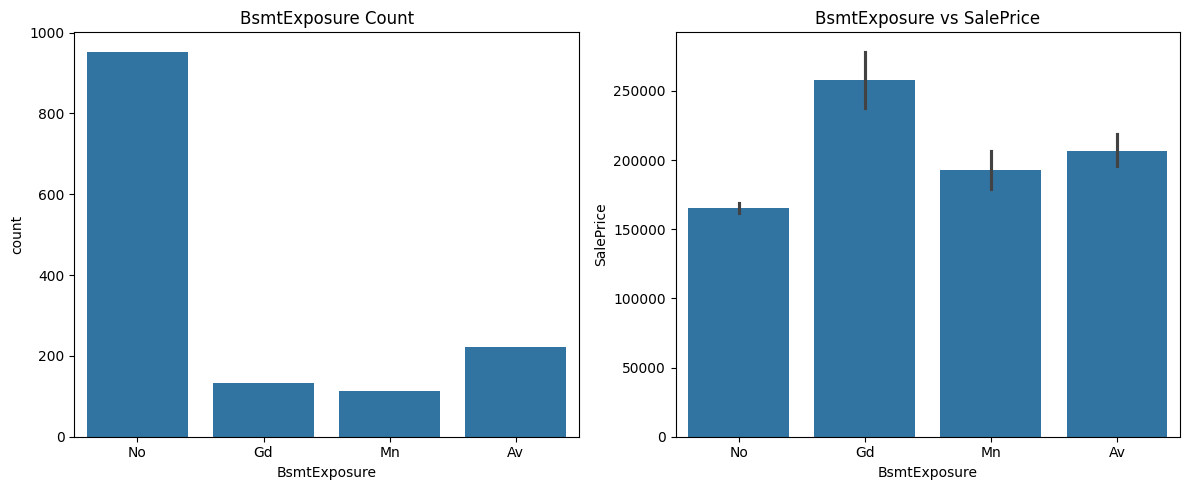

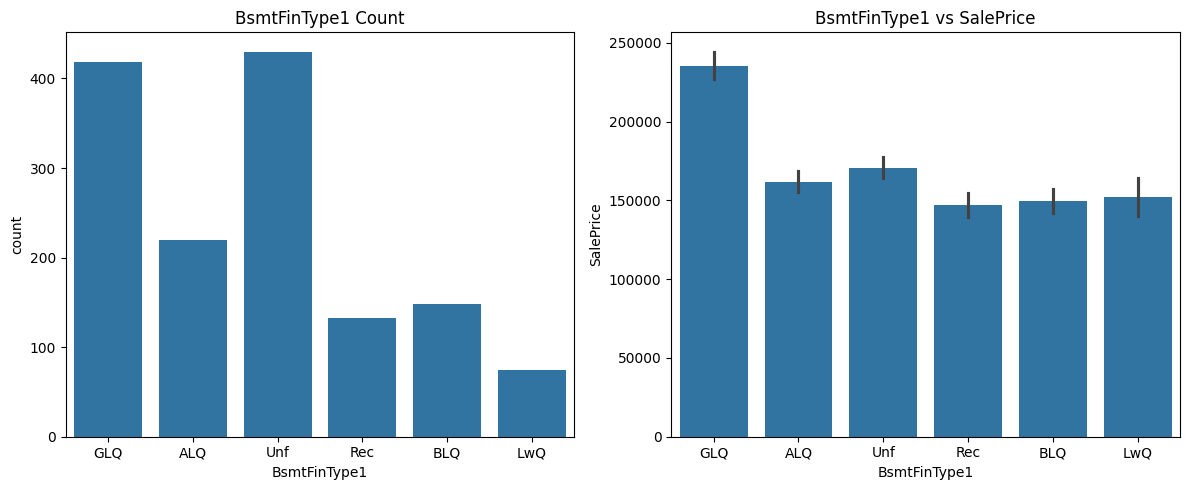

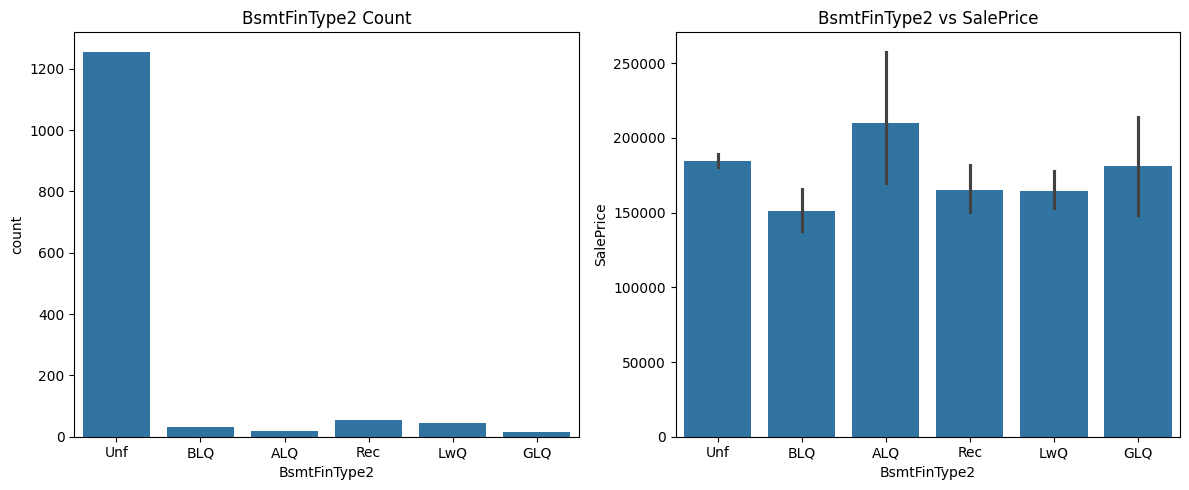

In [193]:
cat_cols_land_4 = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for feature in cat_cols_land_4:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    # axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    # axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Basement Quality:
- Basement quality refers to the height of the basement. So excellent means more than 100 inches and poor means less than 70 inches.
So a property with a good quality basement will have a higher selling price.

Basement Exposure:
- Basements with good exposure to the garden or walkouts have higher selling prices and properties without basements or those with no exposure have lower selling prices.

Basement Condition:
- Average and Good conditions have higher selling prices as seen in other cases.

Basement types 1 and 2::
- Good, average residences and unfinished basements have a higher average sales price in both type 1 and type 2 and below average finishes will obviously have a lower value.

### Heating and Air Conditioning

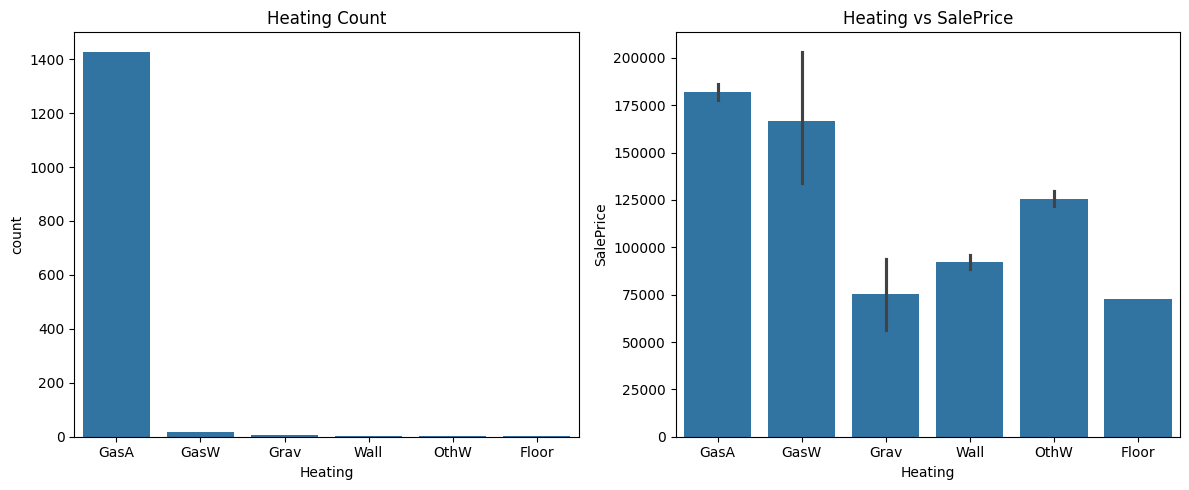

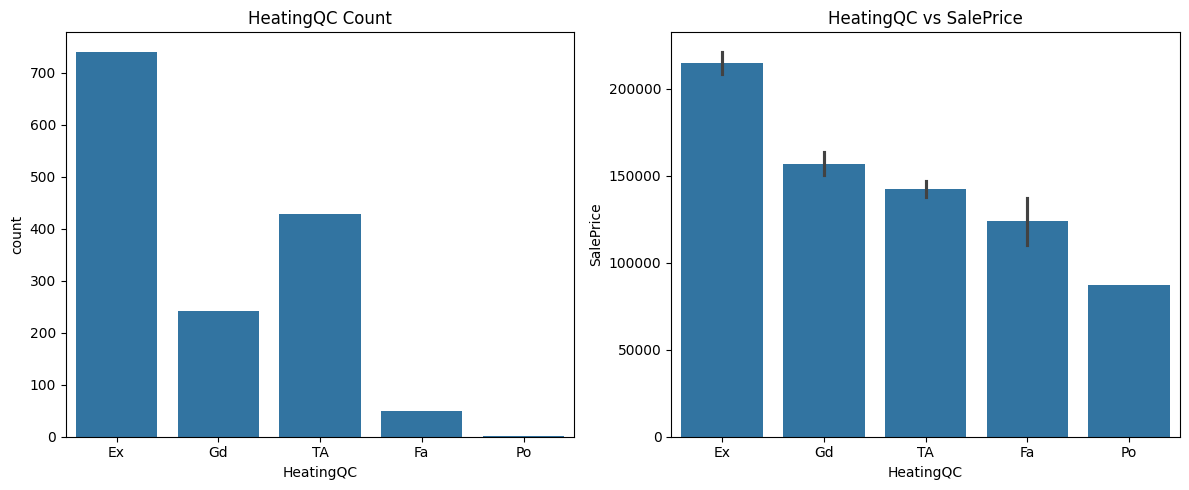

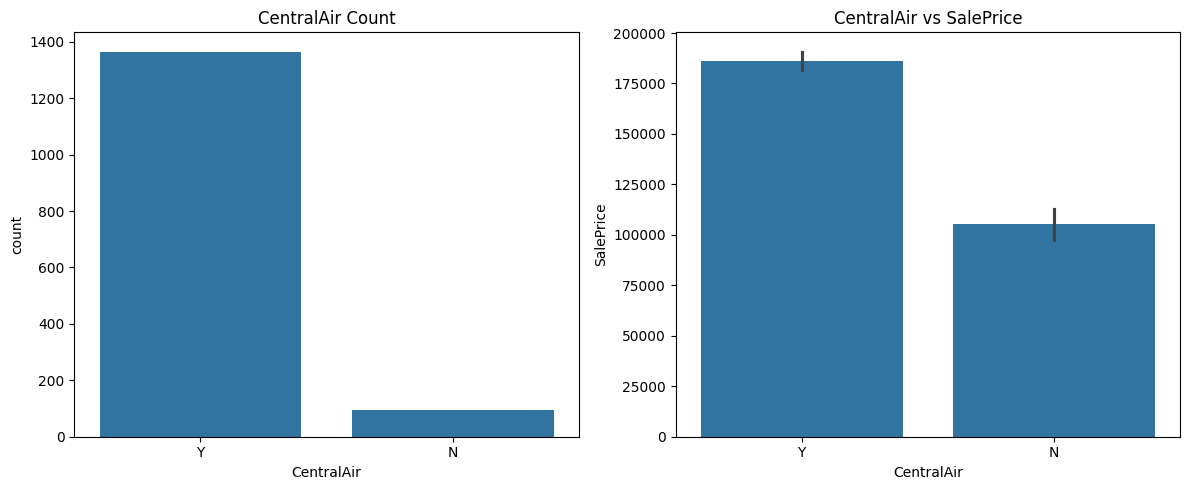

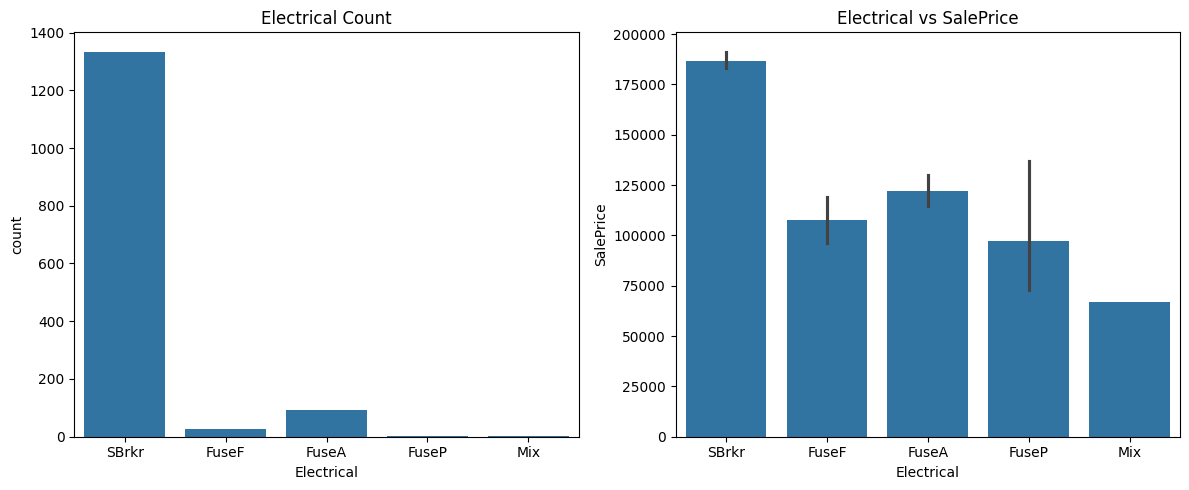

In [194]:
cat_cols_land_5 = ['Heating', 'HeatingQC', 'CentralAir','Electrical']

for feature in cat_cols_land_5:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    # axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    # axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Electrical:
- Most properties have standard circuit breakers and have the highest average sales price of 170,000.
Properties with poor fuse box systems and mixed systems have sale prices of less than 100,000.

Warmup :
- Wall heating or hot water/steam are associated with low house prices. Gases formed in warm air appear to push selling prices higher.

Central AC:
- Most properties are AC, and those that have AC will be more expensive than those that don't have it.

### Garage

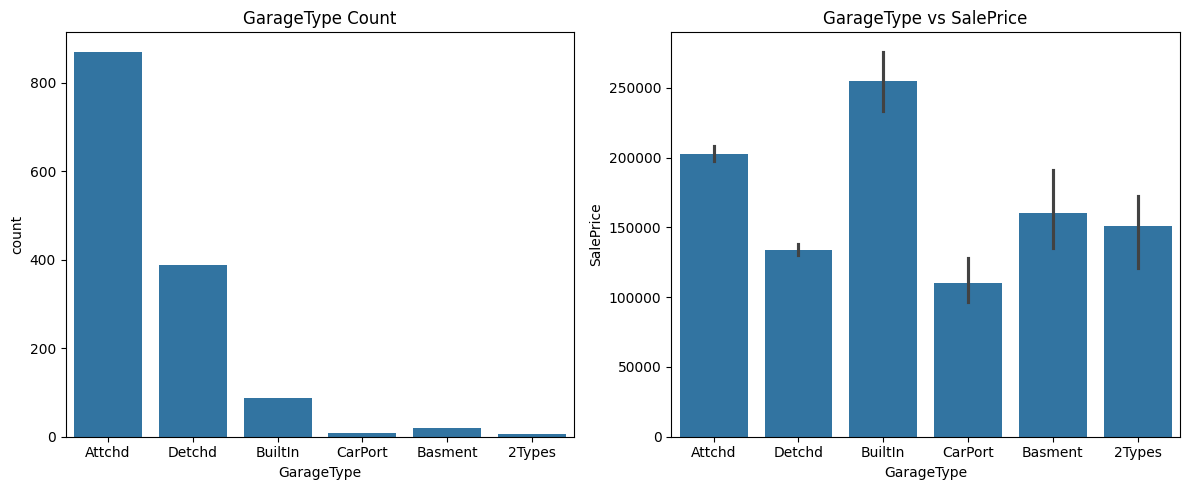

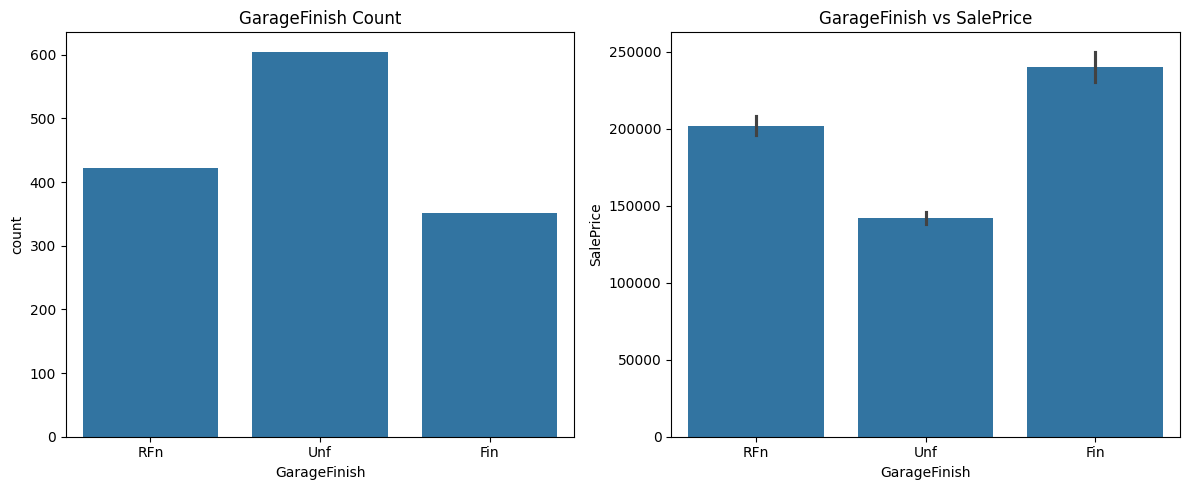

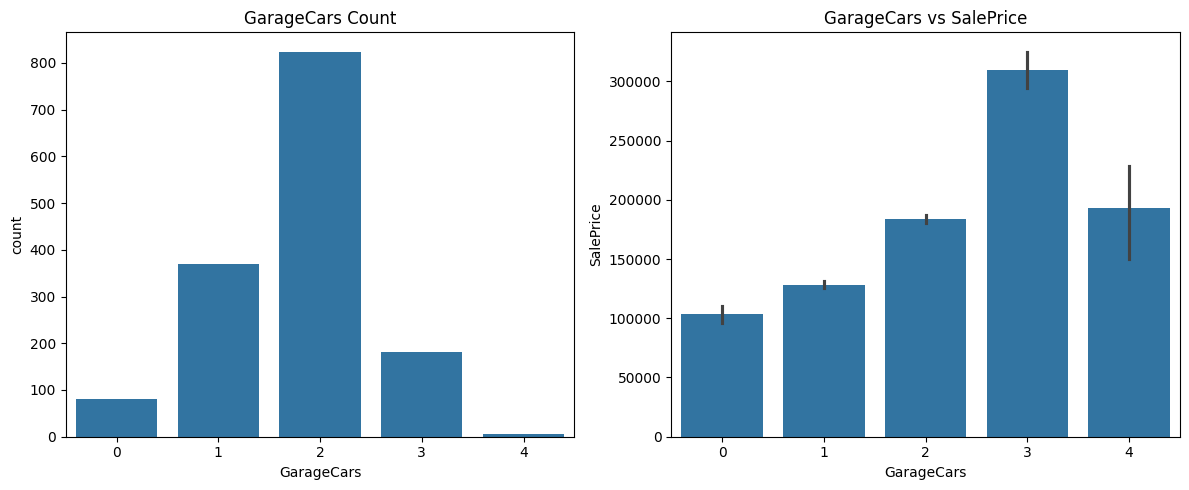

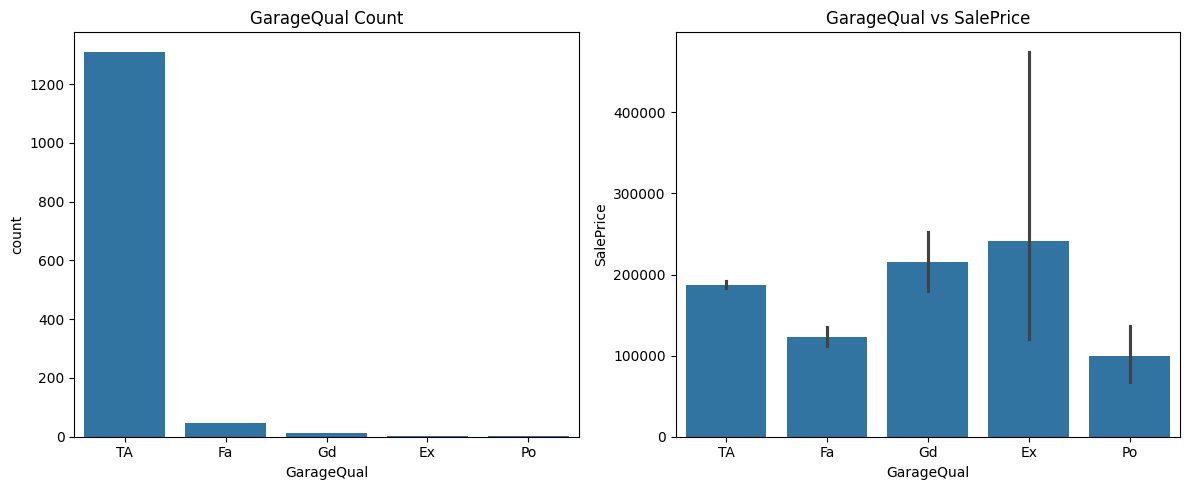

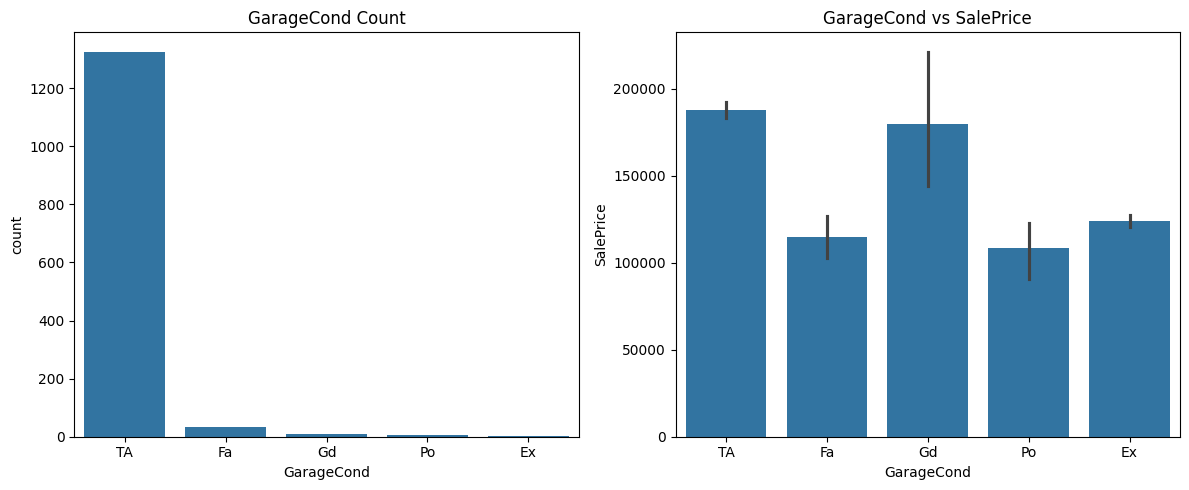

In [195]:
cat_cols_land_6 = ['GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond']

for feature in cat_cols_land_6:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    # axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    # axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Garage Type:
- Homes with attached garages tend to command the highest prices. Those that don't have a garage or car port tend to have the cheapest prices.

Garage Finish:
- Finished and approximately finished garages have a higher selling price than unfinished ones. And properties that don't have a garage have the cheapest prices, but this type mostly doesn't have a garage

GarageCars :
- Here car garage refers to the size of the garage in terms of car capacity. So the higher the number, the greater the selling price.

In [196]:
# for feature in categorical_cols:
#     sns.countplot(y=feature, data=df)
#     plt.show()

### Sale Type and Condition

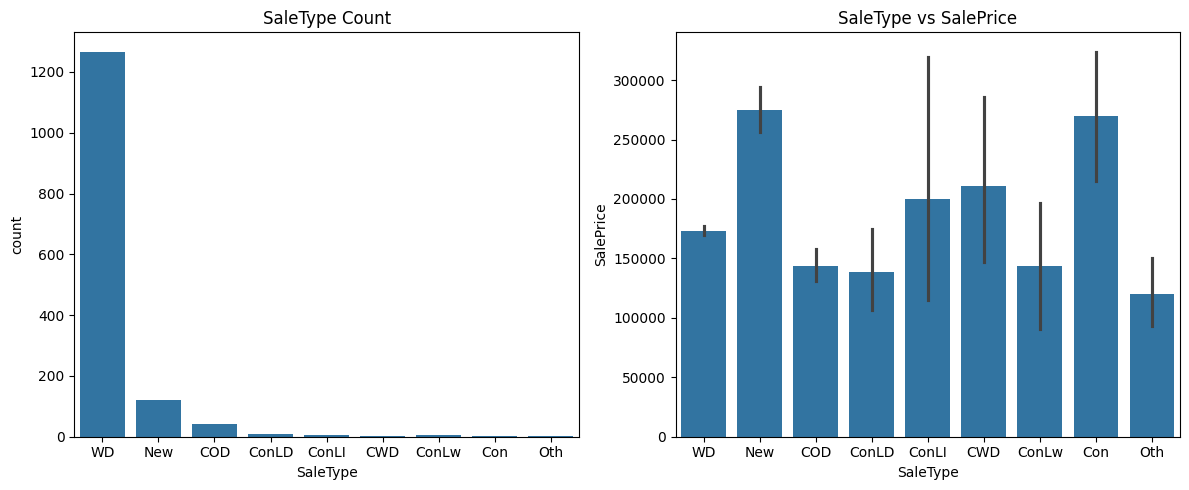

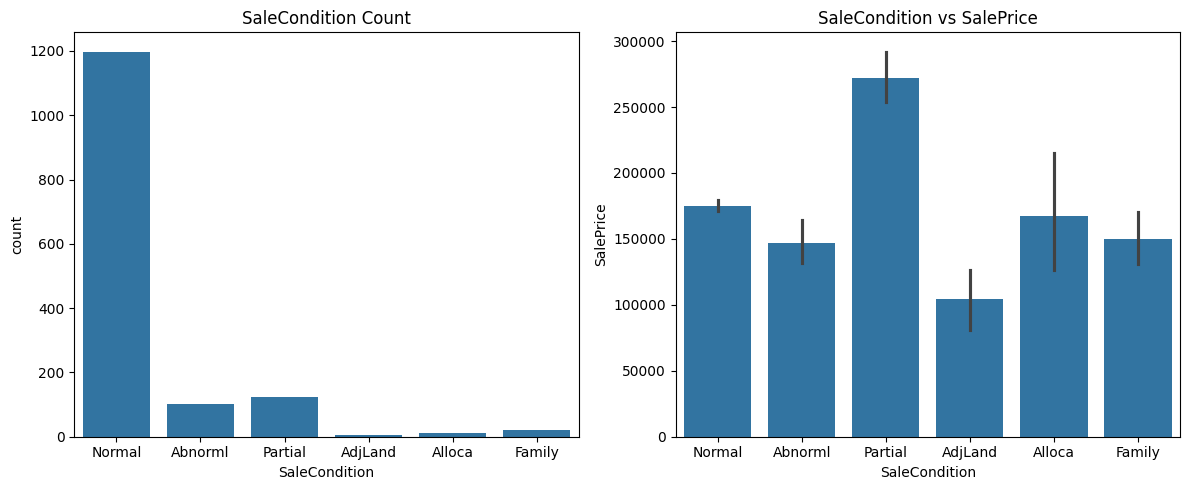

In [197]:
cat_cols_land_7 = ['SaleType','SaleCondition']
for feature in cat_cols_land_7:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    # axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    # axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Sales Type:
- Most properties are under warranty deed sale. Homes where homes are for sale seem to have different price ranges.

Sale Condition:
- There are more houses in normal condition. If the house for sale is in partial or normal condition, the price will definitely be higher than in other conditions.

## Numerical Analysis

### Discrete Numerical Analysis

In [198]:
discrete=[]
for col in df.columns:
    if df[col].dtype=='int64' :
        discrete.append(col)

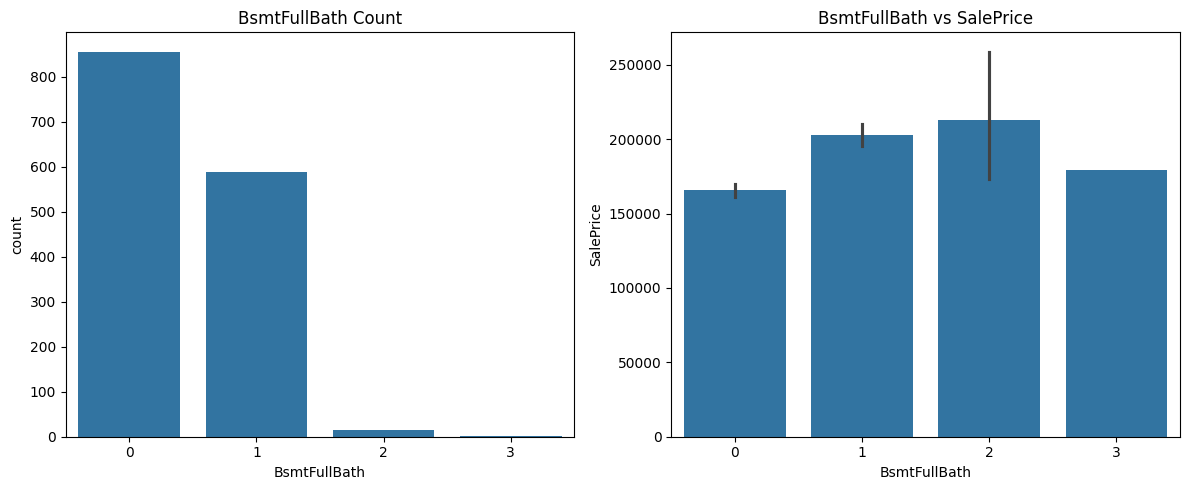

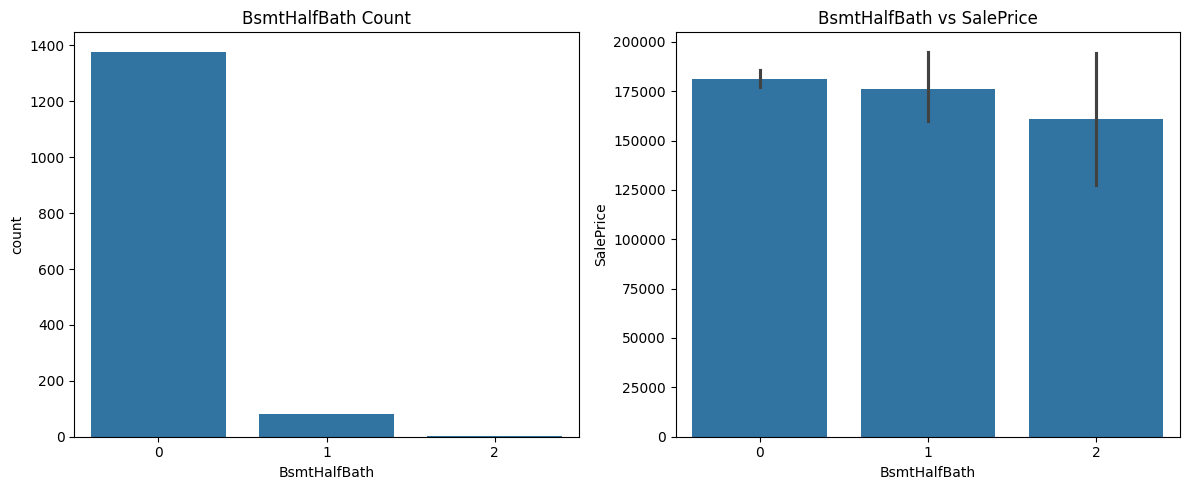

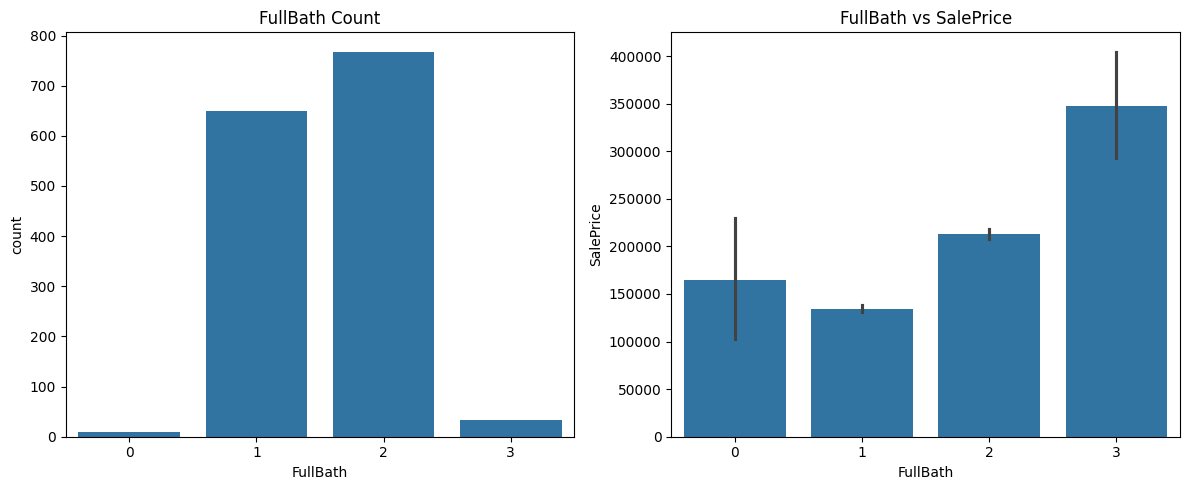

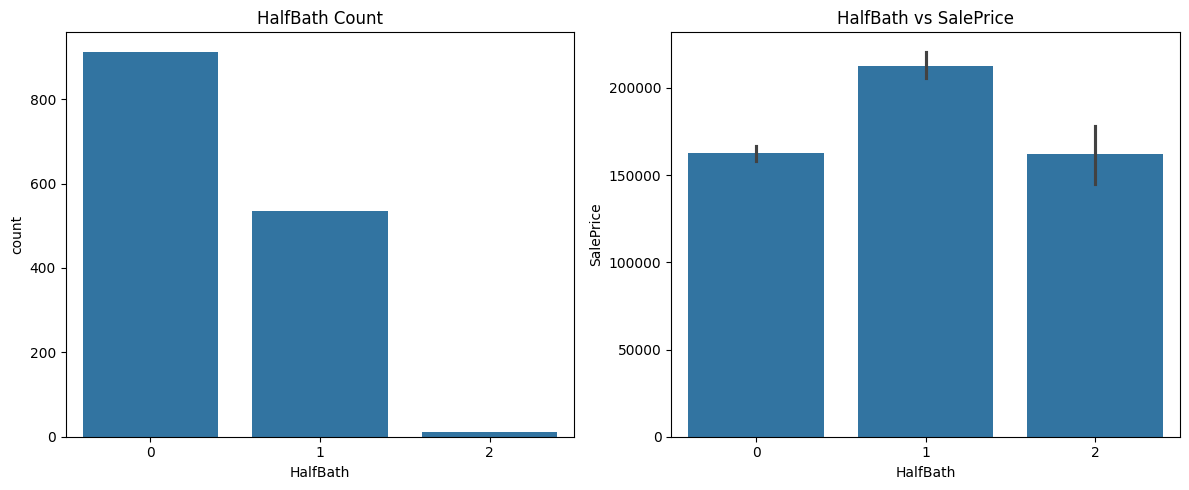

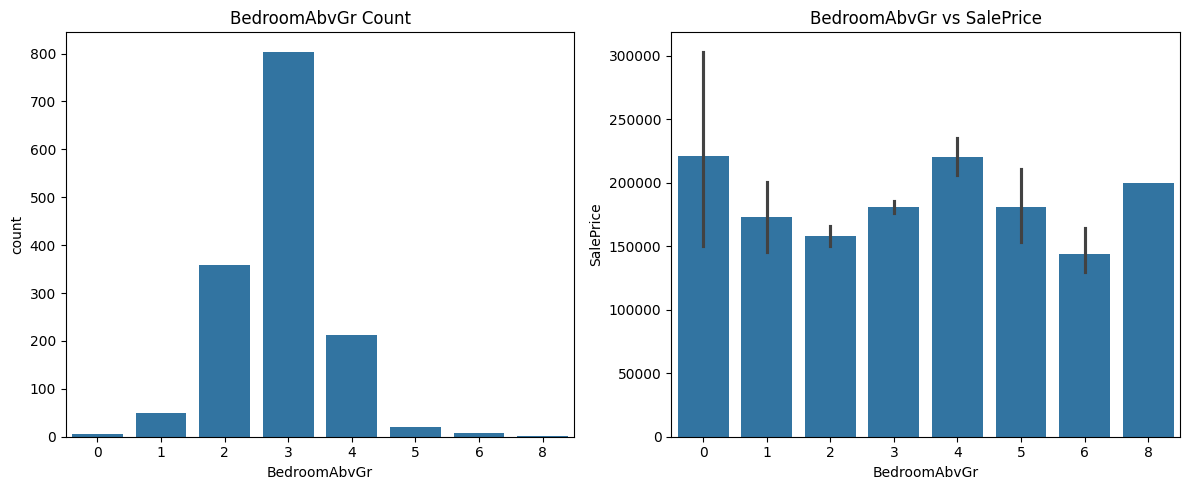

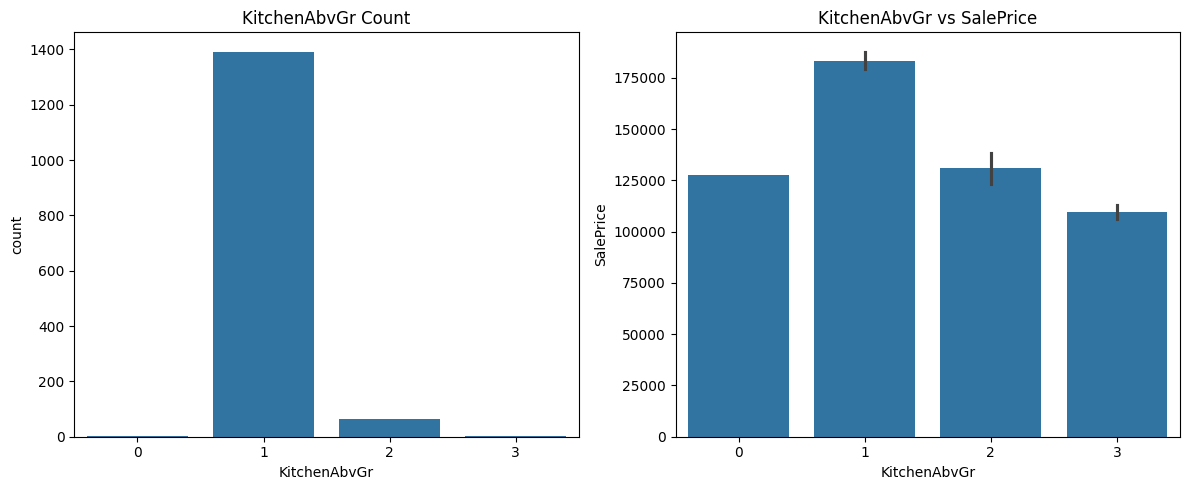

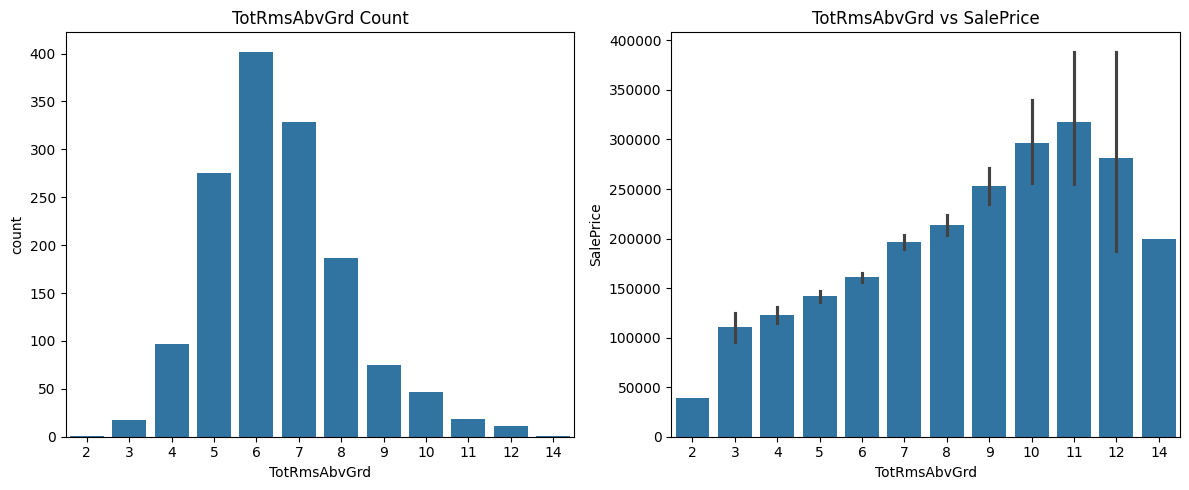

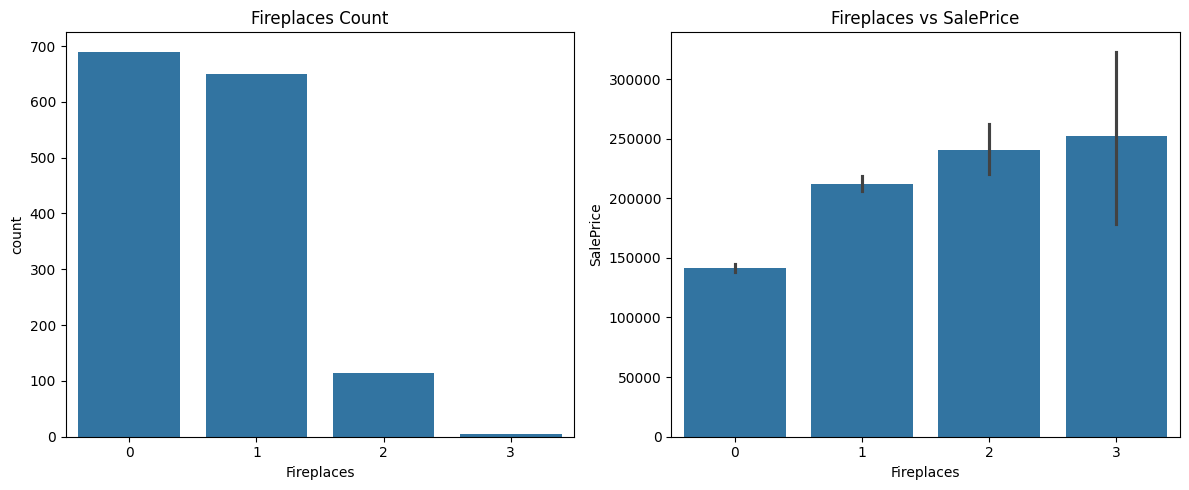

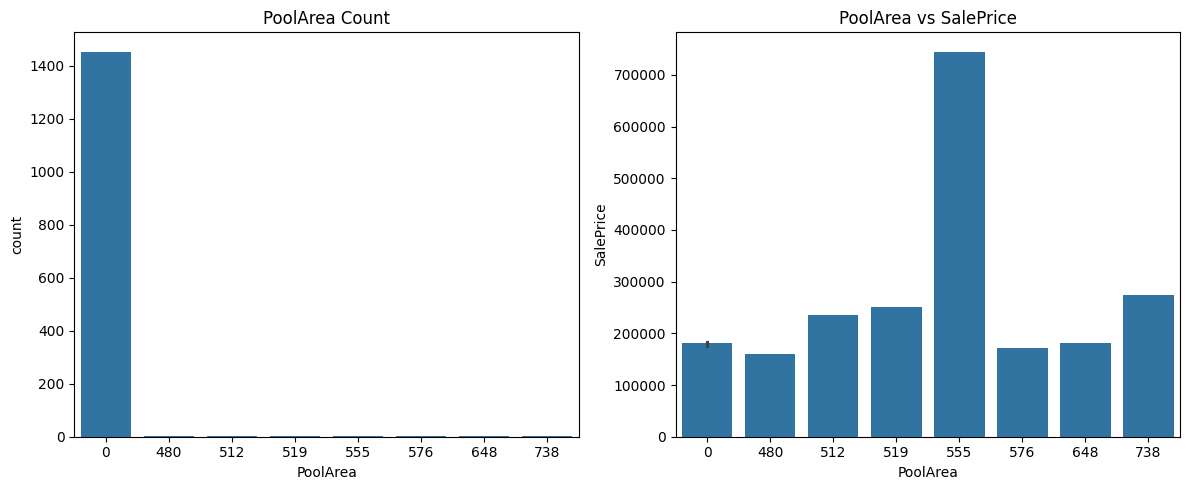

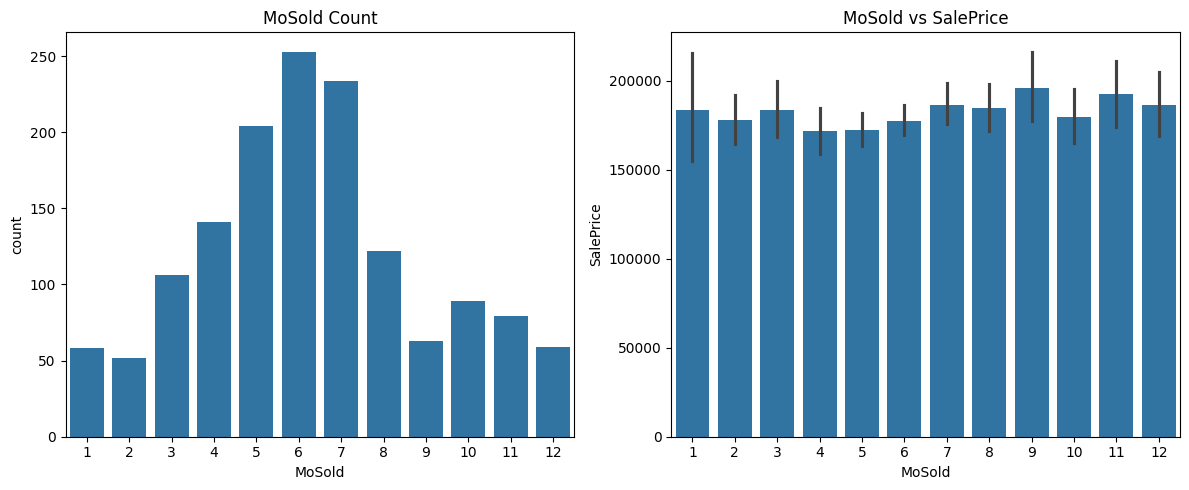

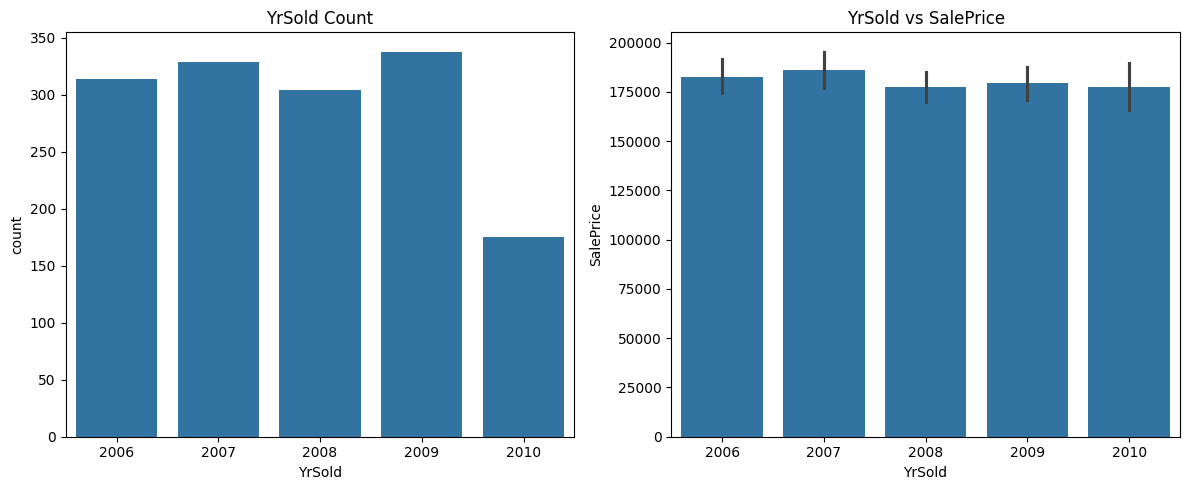

In [199]:
cat_cols_land_8 =['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'PoolArea', 'MoSold', 'YrSold']
for feature in cat_cols_land_8:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.countplot(data=df, x=feature, ax=axes[0])
    axes[0].set_title(f'{feature} Count')
    # axes[0].tick_params(axis='x', rotation=90)

    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[1])
    axes[1].set_title(f'{feature} vs SalePrice')
    # axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Along with the increase in the number of rooms above ground, the average price increased to 11 rooms, after which there was a decline. The exponential curve is not visible for the number of bedrooms above ground, with prices highest for 0 bedrooms, followed by 4 and 8 bedrooms. The number of kitchens on the ground also influences the price, but with a decreasing trend as the number of kitchens increases. In particular, homes with one kitchen command the highest prices. Analysis of bathrooms shows that homes with 3 full bathrooms command the highest prices, while homes without bathrooms tend to be cheaper. The presence of a fireplace in the house and the size of the swimming pool also contribute to the increase in selling prices. Year of sale shows a slight decline from 2006 to 2010, while month of sale does not provide significant insight into home sales prices.

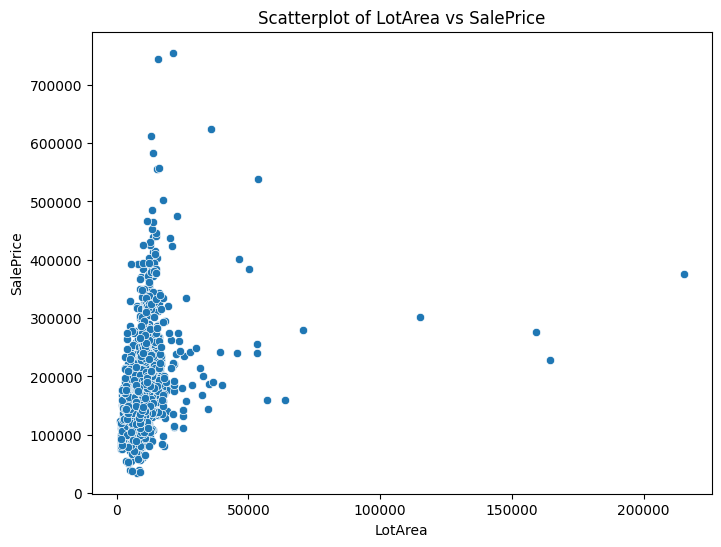

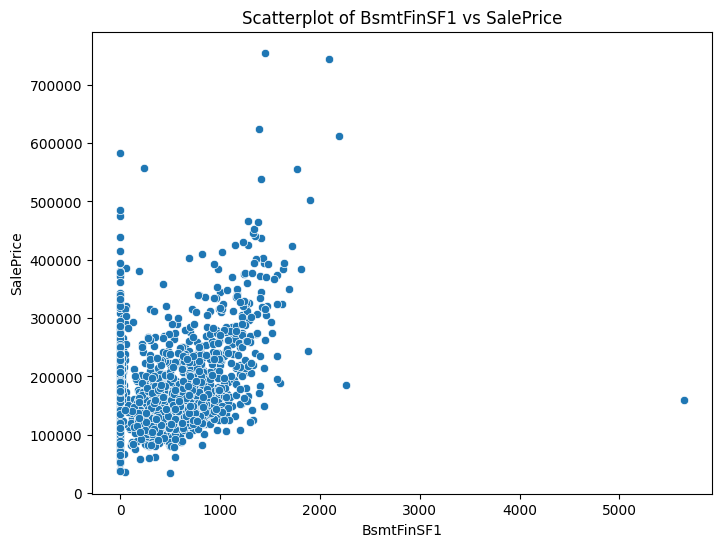

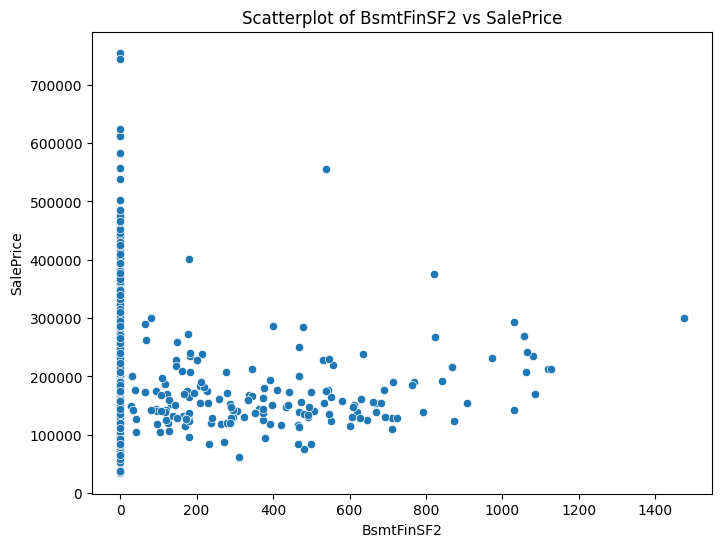

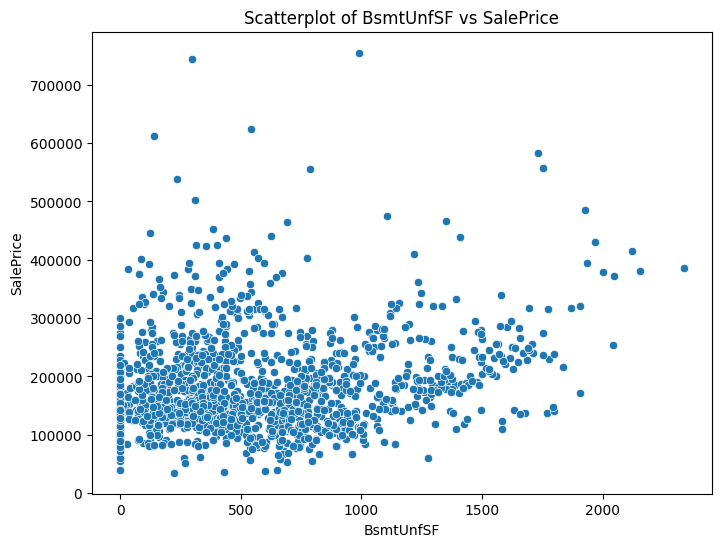

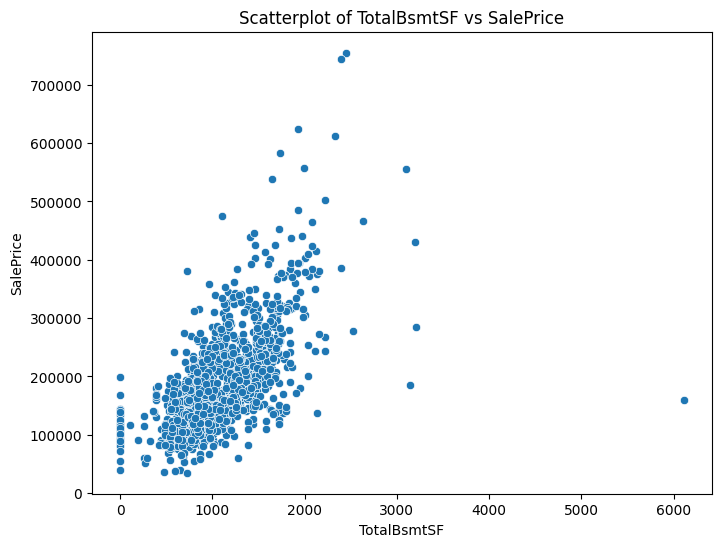

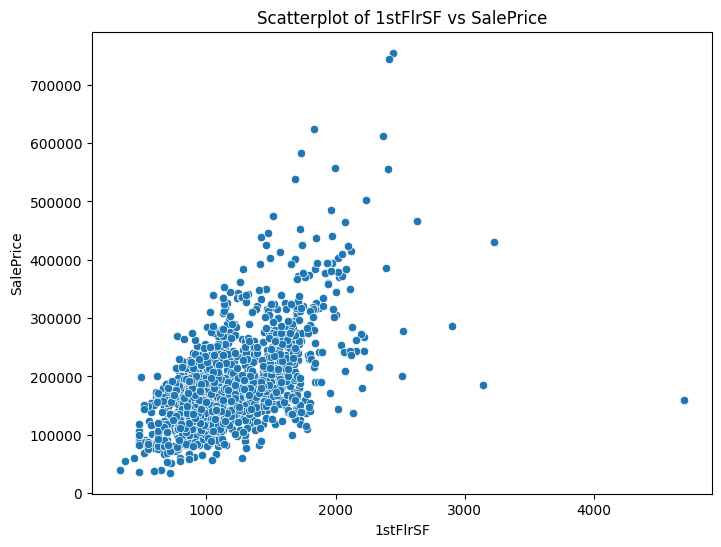

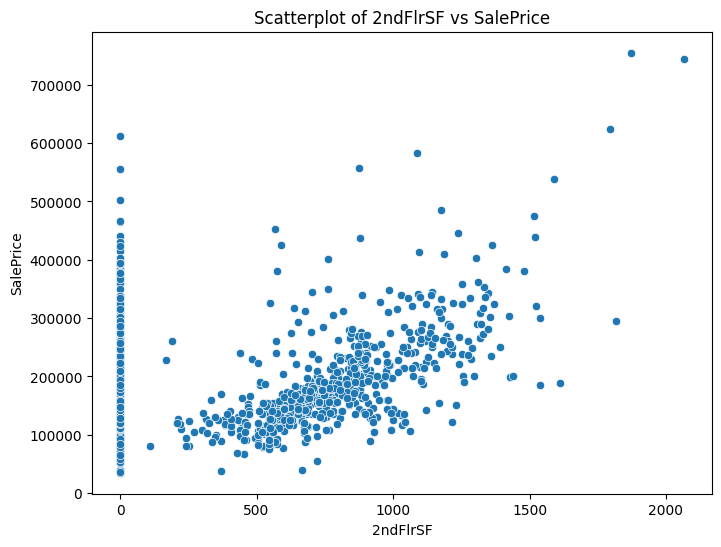

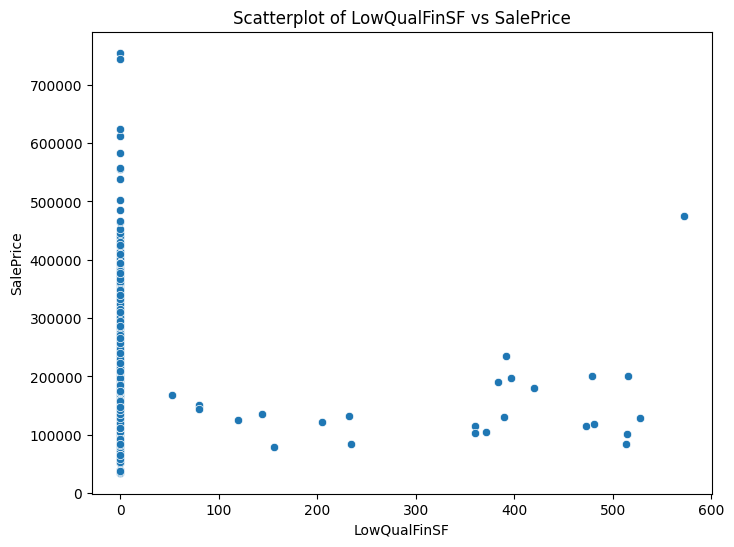

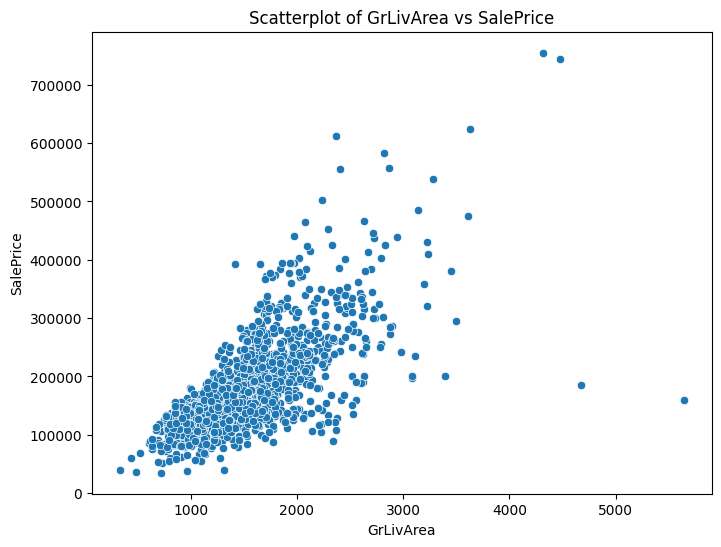

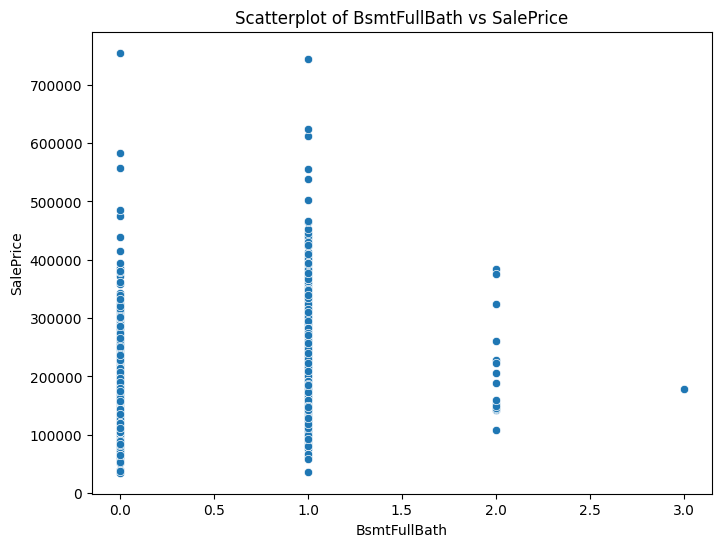

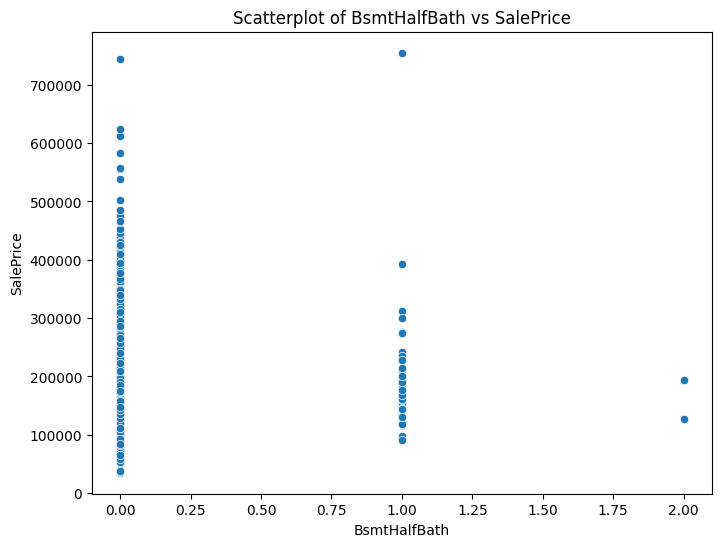

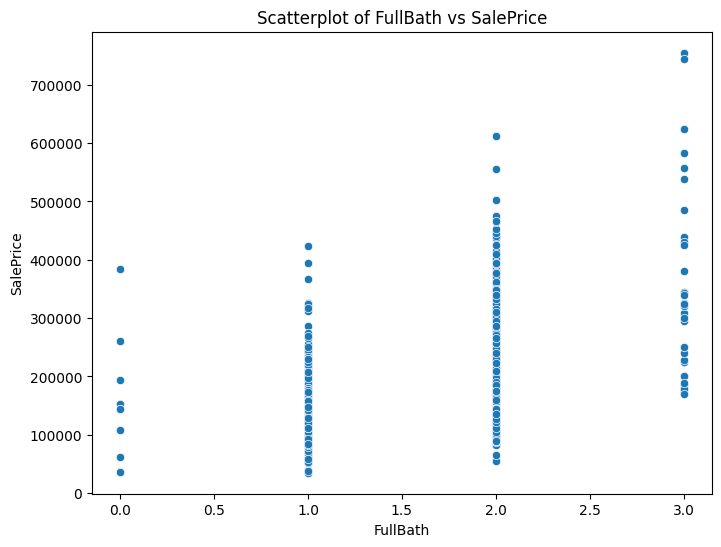

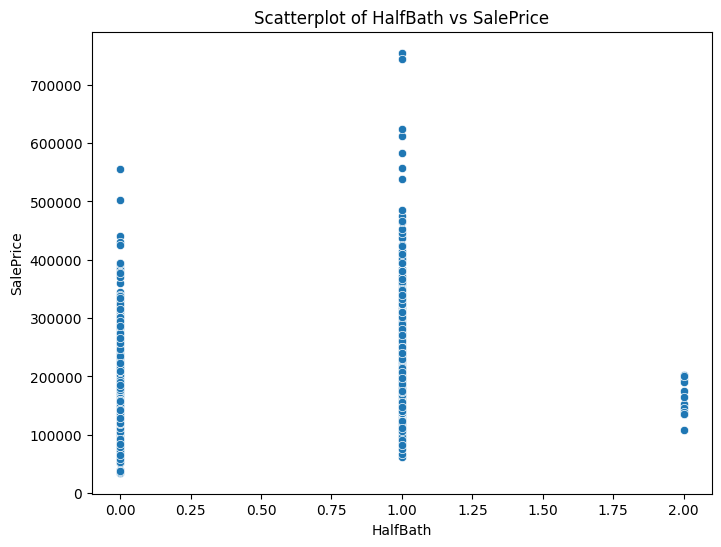

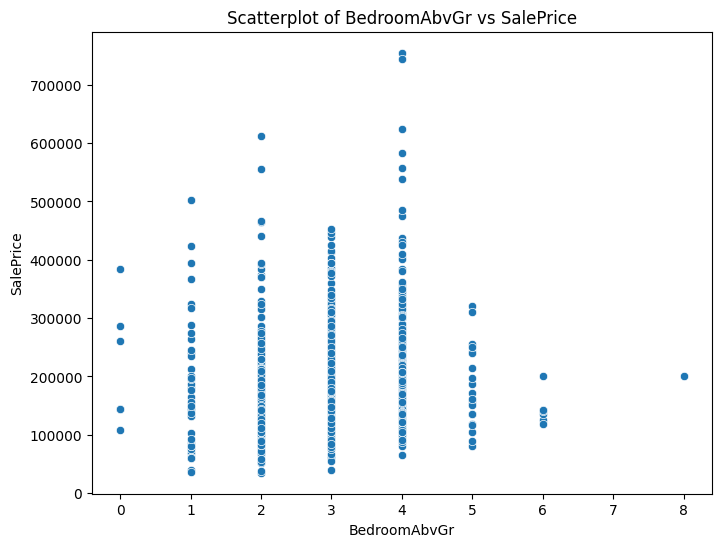

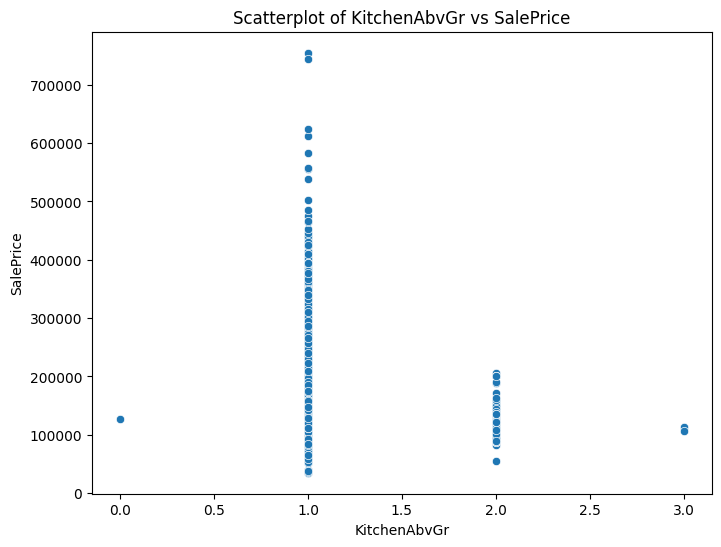

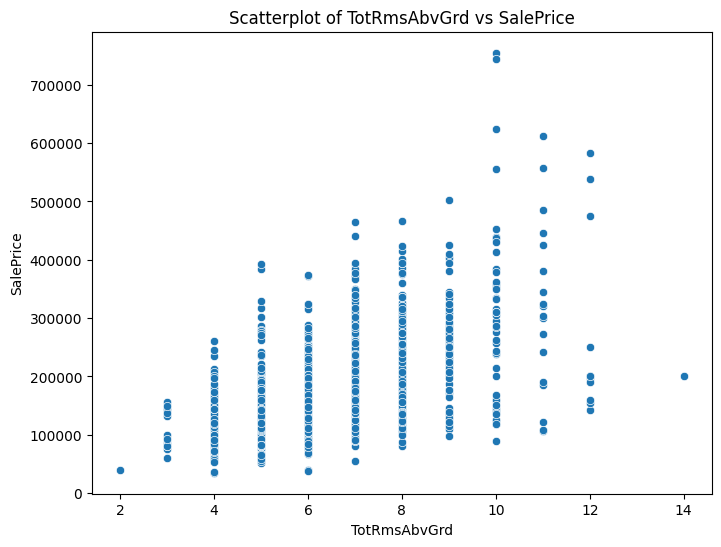

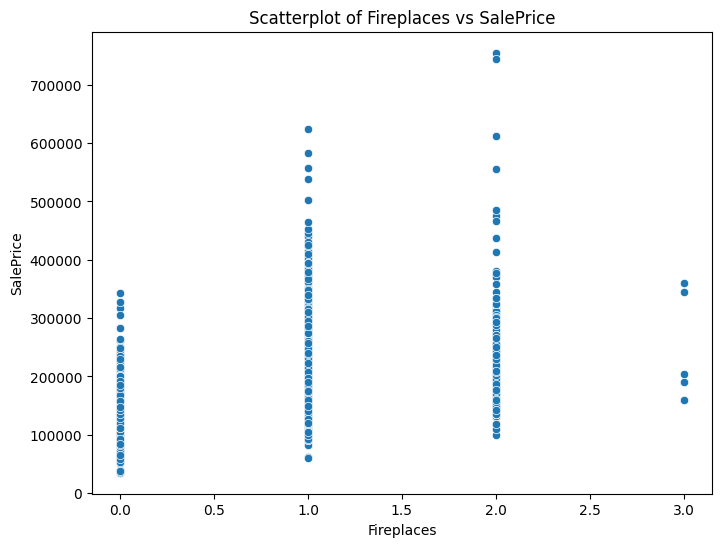

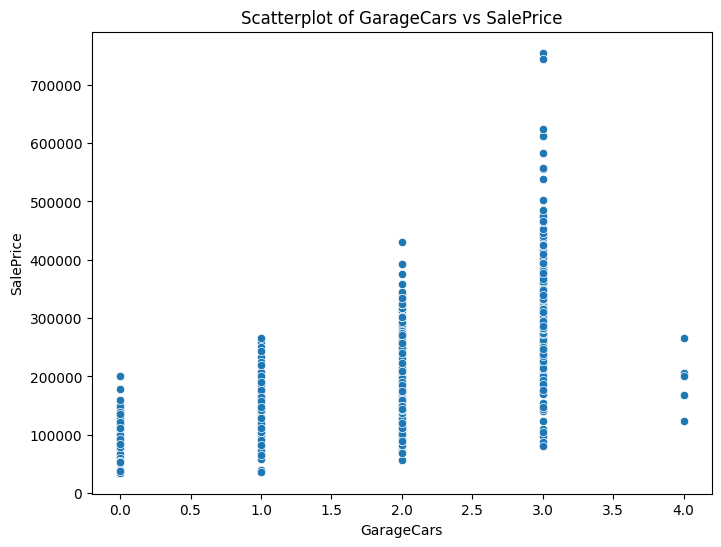

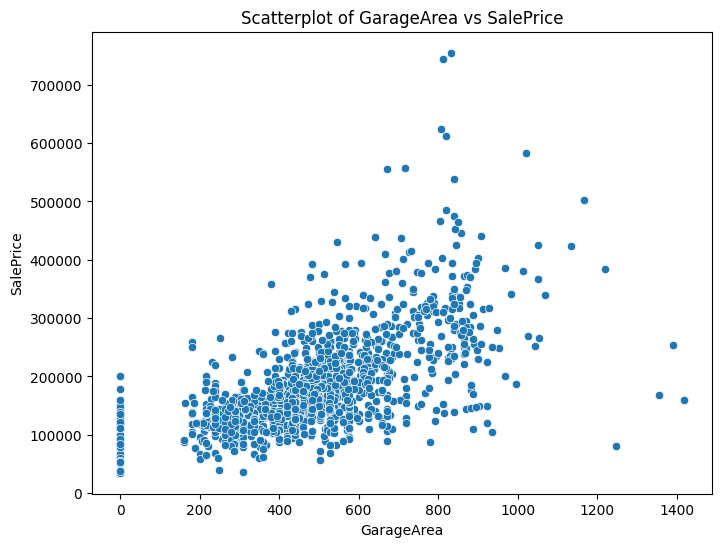

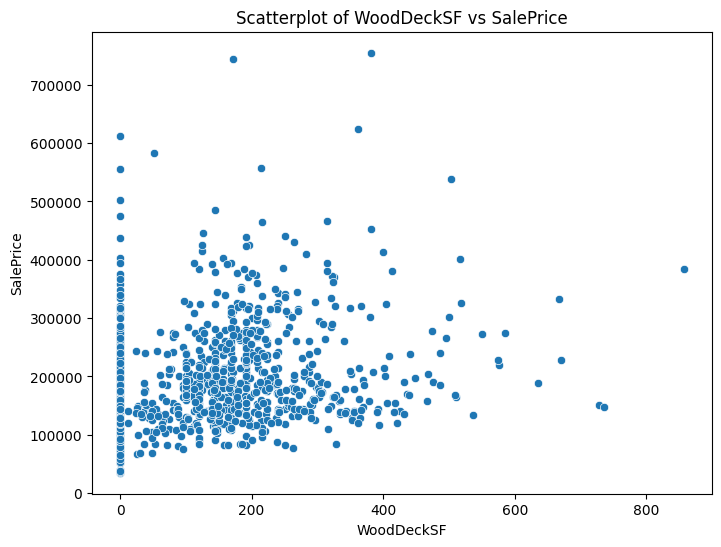

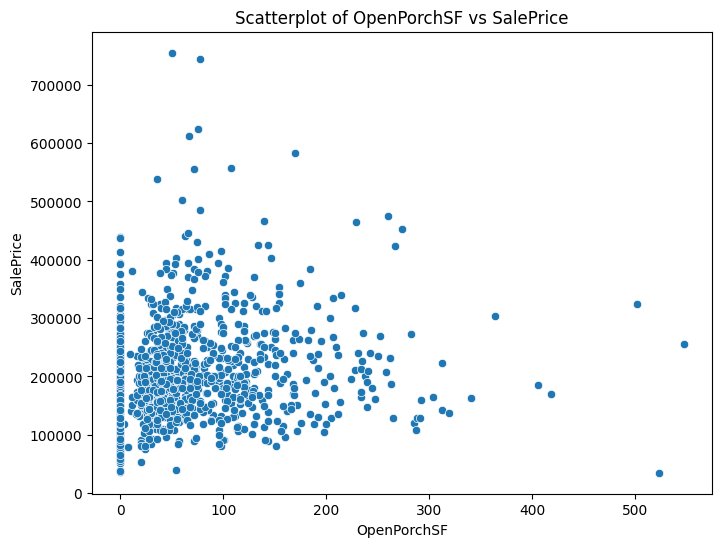

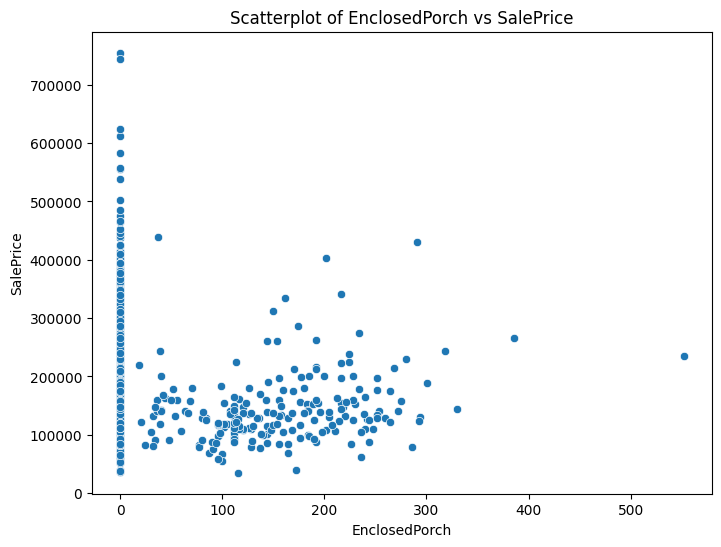

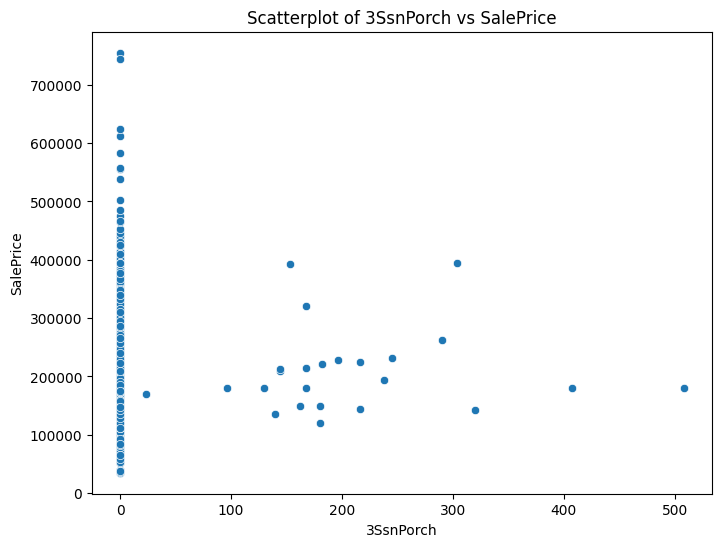

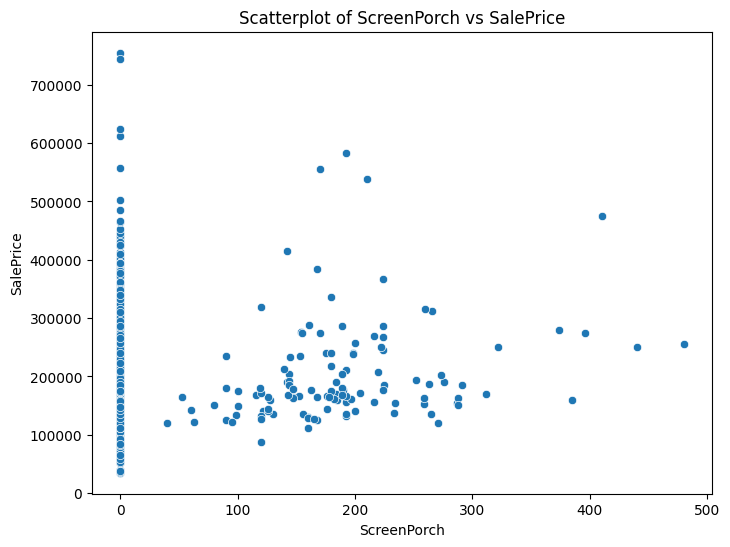

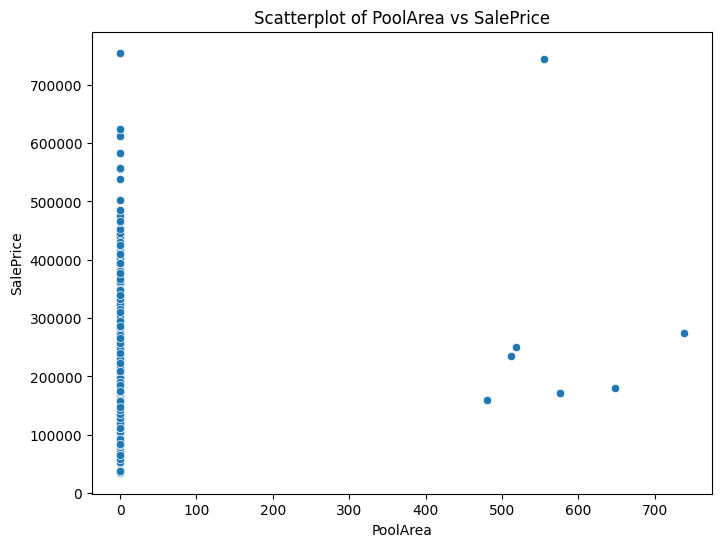

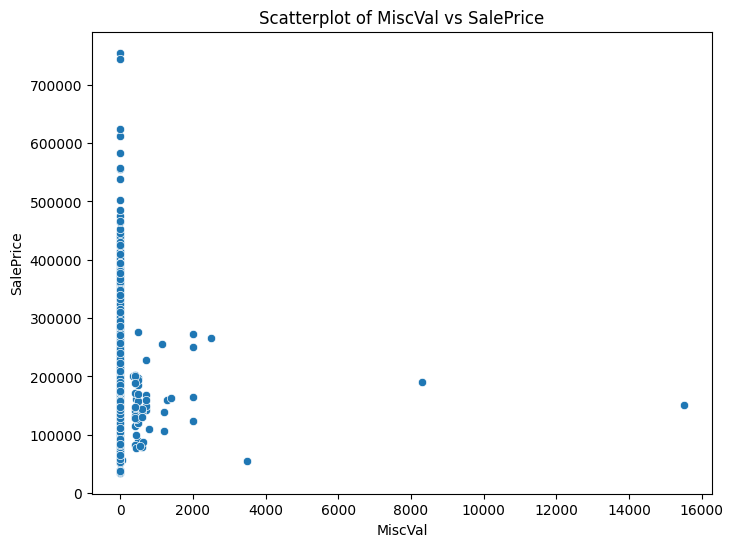

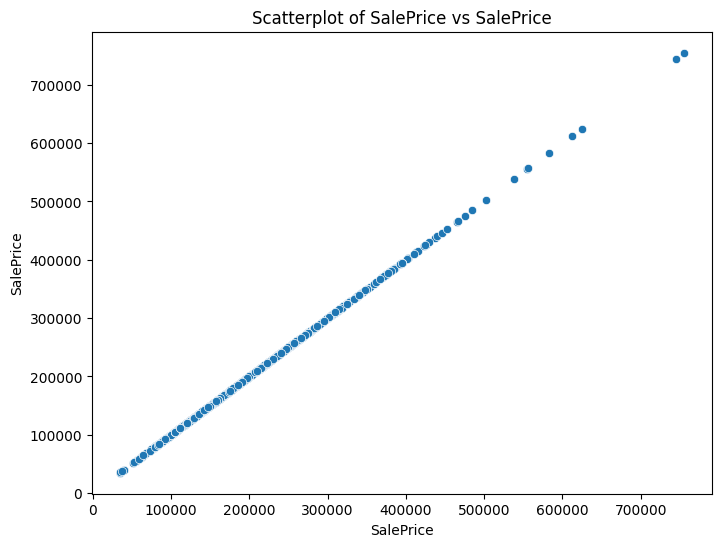

In [200]:
selected_numeric_columns = [col for col in df.columns if col not in ['Id','MSSubClass','OverallQual','OverallCond','YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageYrBlt'] and df[col].dtype=='int64']

for col in selected_numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='SalePrice', data=df)
    plt.title(f'Scatterplot of {col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

As the number of features increases, the selling price increases, such as the total surface area of the Basement and the surface area of the 1st floor, Garage, Full Bath, TotRmsAbvGrd

## Feature Egnineering

In [201]:
print(f"Dataframe dimension before duplication drop {df.shape[0]}")

df = df.drop_duplicates().reset_index(drop=True)

print(f"Dataframe dimension after duplication drop {df.shape[0]}")

Dataframe dimension before duplication drop 1460
Dataframe dimension after duplication drop 1460


### Handling Missing Value

In [202]:
total = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head(20)

,Total
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


Filling missing values For some columns there are many NaN entries. However, when re-reading the data description, there is some evidence that this is not missing data: For PoolQC, NaN is not missing data but means there is no pool, similarly for Fence, FireplaceQu, etc.

In [203]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df[col].fillna('None',inplace=True)

In [204]:
total = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head(5)

,Total
LotFrontage,259
GarageYrBlt,81
MasVnrArea,8
Id,0
KitchenAbvGr,0


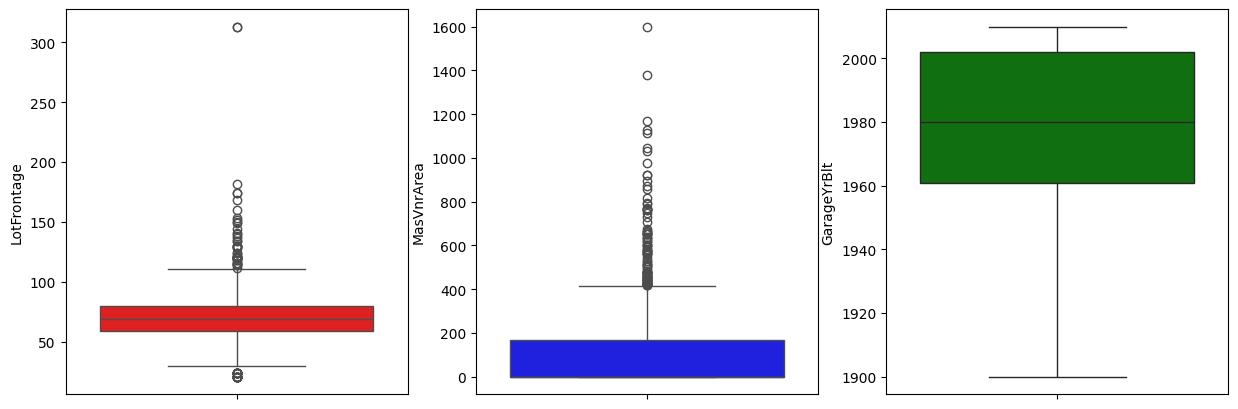

In [205]:
plt.figure(figsize=(15,5))

features_to_examine = ['LotFrontage','MasVnrArea','GarageYrBlt']
temp = df[features_to_examine]
colors=['','red','blue','green']
i=1
for col in temp.columns:
    plt.subplot(1,3,i)
    a1 = sns.boxplot(data=temp,y=col,color=colors[i])
    i+=1

In [206]:
df['LotFrontage'].mean(),df['LotFrontage'].median()

(70.04995836802665, 69.0)

In [207]:
df['MasVnrArea'].mean(),df['MasVnrArea'].median()

(103.68526170798899, 0.0)

In [208]:
df['GarageYrBlt'].mean(),df['GarageYrBlt'].median()

(1978.5061638868744, 1980.0)

In [209]:
features_to_examine

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [210]:
for col in features_to_examine:
    df[col].fillna(df[col].median(),inplace=True)

In [211]:
df[features_to_examine].isna().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [212]:
df.isnull().sum().sort_values(ascending=False)

Id             0
CentralAir     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 81, dtype: int64

In [213]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


### Label Encoder

Converts categorical text data to numeric data for the model to understand

In [214]:
categorical_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [215]:
le = LabelEncoder()

for column in categorical_cols:
    df[column] = le.fit_transform(df[column])

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int32  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int32  
 6   Alley          1460 non-null   int32  
 7   LotShape       1460 non-null   int32  
 8   LandContour    1460 non-null   int32  
 9   Utilities      1460 non-null   int32  
 10  LotConfig      1460 non-null   int32  
 11  LandSlope      1460 non-null   int32  
 12  Neighborhood   1460 non-null   int32  
 13  Condition1     1460 non-null   int32  
 14  Condition2     1460 non-null   int32  
 15  BldgType       1460 non-null   int32  
 16  HouseStyle     1460 non-null   int32  
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [217]:
df['Alley'].value_counts()

Alley
1    1369
0      50
2      41
Name: count, dtype: int64

### Feature Scaling

Scale all features so that each feature contributes approximately in proportion to the final Sale Price.
Here we use MinMaxScaler which can reduce the range so that the range is now between 0 and 1.

In [218]:
X=df.drop(columns=['SalePrice','Id'],axis=1)
y=df['SalePrice']

X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
1,20,3,80.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
2,60,3,68.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
3,70,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
4,60,3,84.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,0,4,...,0,0,3,4,1,0,8,2007,8,4
1456,20,3,85.0,13175,1,1,3,3,0,4,...,0,0,3,2,1,0,2,2010,8,4
1457,70,3,66.0,9042,1,1,3,3,0,4,...,0,0,3,0,3,2500,5,2010,8,4
1458,20,3,68.0,9717,1,1,3,3,0,4,...,0,0,3,4,1,0,4,2010,8,4


In [219]:
column_names = X.columns

## Regression

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse_val = np.sqrt(mse)
    return mae, mse, rmse_val, set_name

In [221]:
# Linear Regression
linear_reg_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Linear Regression Evaluation - Train
linear_reg_pipe.fit(X_train, y_train)
linear_reg_scores_train = evaluate_model(linear_reg_pipe, X_train, y_train, "Train")

# Linear Regression Evaluation - Test
linear_reg_scores_test = evaluate_model(linear_reg_pipe, X_test, y_test, "Test")

In [222]:
# SVR
svr_pipe = make_pipeline(StandardScaler(), SVR())

# svr Evaluation - Train
svr_pipe.fit(X_train, y_train)
svr_scores_train = evaluate_model(svr_pipe, X_train, y_train, "Train")

# svr Evaluation - Test
svr_scores_test = evaluate_model(svr_pipe, X_test, y_test, "Test")

In [223]:
# Ridge Regression
ridge_pipe = make_pipeline(StandardScaler(), Ridge())

# Ridge Evaluation - Train
ridge_pipe.fit(X_train, y_train)
ridge_scores_train = evaluate_model(ridge_pipe, X_train, y_train, "Train")

# Ridge Evaluation - Test
ridge_scores_test = evaluate_model(ridge_pipe, X_test, y_test, "Test")

In [224]:
# XGBoost Regressor
xgboost_pipe = make_pipeline(StandardScaler(), xgb.XGBRegressor())

# XGBoost Evaluation - Train
xgboost_pipe.fit(X_train, y_train)
xgboost_scores_train = evaluate_model(xgboost_pipe, X_train, y_train, "Train")

# XGBoost Evaluation - Test
xgboost_scores_test = evaluate_model(xgboost_pipe, X_test, y_test, "Test")

In [225]:
# Displaying evaluation results
models_scores = [
    ['Linear Regression', *linear_reg_scores_train],
    ['Linear Regression', *linear_reg_scores_test],
    ['SVR', *svr_scores_train],
    ['SVR', *svr_scores_test],
    ['Ridge', *ridge_scores_train],
    ['Ridge', *ridge_scores_test],
    ['XGBoost', *xgboost_scores_train],
    ['XGBoost', *xgboost_scores_test]
]

for model, mae, mse, rmse_val, set_name in models_scores:
    print(f'{model} - {set_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse_val:.4f}')

Linear Regression - Train - MAE: 18499.7755, MSE: 881852356.5124, RMSE: 29695.9990
Linear Regression - Test - MAE: 21777.6201, MSE: 1207541538.7758, RMSE: 34749.6984
SVR - Train - MAE: 54514.0526, MSE: 6230338704.7444, RMSE: 78932.4946
SVR - Test - MAE: 59530.1669, MSE: 7856733285.5011, RMSE: 88638.2157
Ridge - Train - MAE: 18494.9526, MSE: 881885863.7397, RMSE: 29696.5632
Ridge - Test - MAE: 21774.6142, MSE: 1206081941.7817, RMSE: 34728.6905
XGBoost - Train - MAE: 700.9153, MSE: 1042819.5524, RMSE: 1021.1854
XGBoost - Test - MAE: 16765.3164, MSE: 680486605.6182, RMSE: 26086.1382


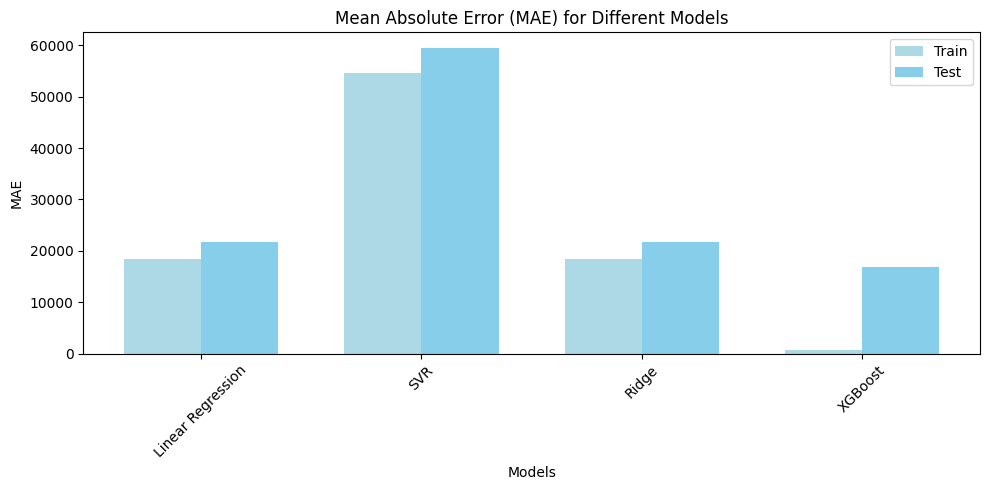

In [226]:
# Collecting MAE values for both training and testing
mae_values_train = [linear_reg_scores_train[0], svr_scores_train[0], ridge_scores_train[0], xgboost_scores_train[0]]
mae_values_test = [linear_reg_scores_test[0], svr_scores_test[0], ridge_scores_test[0], xgboost_scores_test[0]]

# Plotting Mean Absolute Error (MAE) for Different Models
models = ['Linear Regression', 'SVR', 'Ridge', 'XGBoost']
width = 0.35  # the width of the bars
models_indices = np.arange(len(models))

plt.figure(figsize=(10, 5))

bar1 = plt.bar(models_indices - width/2, mae_values_train, width, label='Train', color='lightblue')
bar2 = plt.bar(models_indices + width/2, mae_values_test, width, label='Test', color='skyblue')

plt.title('Mean Absolute Error (MAE) for Different Models')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.xticks(models_indices, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


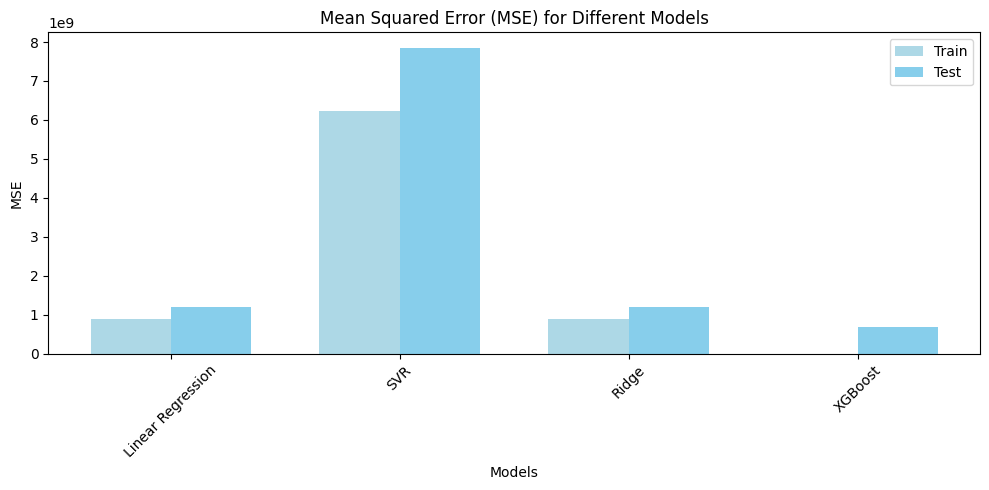

In [227]:
mse_values_train = [linear_reg_scores_train[1], svr_scores_train[1], ridge_scores_train[1], xgboost_scores_train[1]]
mse_values_test = [linear_reg_scores_test[1], svr_scores_test[1], ridge_scores_test[1], xgboost_scores_test[1]]

# Plotting Mean Squared Error (MSE) for Different Models
models = ['Linear Regression', 'SVR', 'Ridge', 'XGBoost']
width = 0.35  # the width of the bars
models_indices = np.arange(len(models))

plt.figure(figsize=(10, 5))

bar1 = plt.bar(models_indices - width/2, mse_values_train, width, label='Train', color='lightblue')
bar2 = plt.bar(models_indices + width/2, mse_values_test, width, label='Test', color='skyblue')

plt.title('Mean Squared Error (MSE) for Different Models')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(models_indices, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [251]:
def linear_reg_objective(trial):
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    model = LinearRegression()
    model.set_params(alpha=alpha)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold()))
    return -score  # Optimize for negative score as Optuna maximizes

# Optuna objective function for Ridge
def ridge_objective(trial):
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    model = Ridge()
    model.set_params(alpha=alpha)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold()))
    return -score

# Optuna objective function for SVR
def svr_objective(trial):
    C = trial.suggest_float('C', 0.1, 10.0)
    epsilon = trial.suggest_float('epsilon', 0.01, 0.1)
    model = SVR()
    model.set_params(C=C, epsilon=epsilon)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold()))
    return -score

In [252]:
# Hyperparameter tuning with Optuna
def linear_reg_objective(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    model = LinearRegression(fit_intercept=fit_intercept)    
    score = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold()))
    return -score

In [253]:
ridge_study = optuna.create_study(direction='maximize')
ridge_study.optimize(ridge_objective, n_trials=50)
ridge_best_params = ridge_study.best_params
ridge_best_model = Ridge(**ridge_best_params)
ridge_best_model.fit(X_train, y_train)

[I 2024-03-10 10:34:47,064] A new study created in memory with name: no-name-243a2848-2d50-4026-9582-12b3f1b9725e
[I 2024-03-10 10:34:47,146] Trial 0 finished with value: -0.7901190377242183 and parameters: {'alpha': 0.47925564865765446}. Best is trial 0 with value: -0.7901190377242183.
[I 2024-03-10 10:34:47,188] Trial 1 finished with value: -0.7917329469896903 and parameters: {'alpha': 0.8395547359160925}. Best is trial 0 with value: -0.7901190377242183.
[I 2024-03-10 10:34:47,252] Trial 2 finished with value: -0.7890713159200284 and parameters: {'alpha': 0.2949287452271663}. Best is trial 2 with value: -0.7890713159200284.
[I 2024-03-10 10:34:47,310] Trial 3 finished with value: -0.7916826366959164 and parameters: {'alpha': 0.82657705459123}. Best is trial 2 with value: -0.7890713159200284.
[I 2024-03-10 10:34:47,355] Trial 4 finished with value: -0.7896214918112239 and parameters: {'alpha': 0.38766294494233455}. Best is trial 2 with value: -0.7890713159200284.
[I 2024-03-10 10:34:4

Ridge(alpha=0.0007298206950112074)

In [254]:
svr_study = optuna.create_study(direction='maximize')
svr_study.optimize(svr_objective, n_trials=50)
svr_best_params = svr_study.best_params
svr_best_model = SVR(**svr_best_params)
svr_best_model.fit(X_train, y_train)

[I 2024-03-10 10:34:53,963] A new study created in memory with name: no-name-8ad000ec-5232-47f3-875d-e964979788e7
[I 2024-03-10 10:34:54,333] Trial 0 finished with value: 0.043779432106261985 and parameters: {'C': 4.109725758405354, 'epsilon': 0.04867277997469683}. Best is trial 0 with value: 0.043779432106261985.
[I 2024-03-10 10:34:54,667] Trial 1 finished with value: 0.04446914115645435 and parameters: {'C': 1.668052257946956, 'epsilon': 0.019277558062894152}. Best is trial 1 with value: 0.04446914115645435.
[I 2024-03-10 10:34:55,008] Trial 2 finished with value: 0.042714152905253225 and parameters: {'C': 7.116255765015135, 'epsilon': 0.06790022360405264}. Best is trial 1 with value: 0.04446914115645435.
[I 2024-03-10 10:34:55,392] Trial 3 finished with value: 0.04274834247391501 and parameters: {'C': 7.0254476925652645, 'epsilon': 0.06479311996076595}. Best is trial 1 with value: 0.04446914115645435.
[I 2024-03-10 10:34:55,831] Trial 4 finished with value: 0.043672902303095416 and

SVR(C=0.1020775993767477, epsilon=0.03498115578860343)

In [255]:
print("Best Linear Regression Model:", linear_reg_best_model)
print("Best Ridge Model:", ridge_best_model)
print("Best SVR Model:", svr_best_model)

Best Linear Regression Model: LinearRegression()
Best Ridge Model: Ridge(alpha=0.0007298206950112074)
Best SVR Model: SVR(C=0.1020775993767477, epsilon=0.03498115578860343)


In [256]:
y_train_pred_lr = linear_reg_best_model.predict(X_train)
y_test_pred_lr = linear_reg_best_model.predict(X_test)

y_train_pred_ridge = ridge_best_model.predict(X_train)
y_test_pred_ridge = ridge_best_model.predict(X_test)

y_train_pred_svr = svr_best_model.predict(X_train)
y_test_pred_svr = svr_best_model.predict(X_test)

In [258]:
from mlxtend.regressor import StackingCVRegressor

In [259]:
stacking_model = StackingCVRegressor(
    regressors=[linear_reg_best_model, ridge_best_model, svr_best_model],
    meta_regressor=LinearRegression(),
    cv=5
)
stacking_model.fit(X_train, y_train)

# Predictions on train and test set for stacked model
y_train_pred_stacked = stacking_model.predict(X_train)
y_test_pred_stacked = stacking_model.predict(X_test)

In [260]:
# Print metrics for each model
print("\nMetrics for Linear Regression Model:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_lr))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_lr))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_lr))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_lr))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))

print("\nMetrics for Ridge Model:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_ridge))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_ridge))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_ridge))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_ridge))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))

print("\nMetrics for SVR Model:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_svr))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_svr))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_svr))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_svr))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_svr)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_svr)))

print("\nMetrics for Stacked Model:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_stacked))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_stacked))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_stacked))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_stacked))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_stacked)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_stacked)))


Metrics for Linear Regression Model:
Train MSE: 881879732.5642198
Test MSE: 1207136598.4113438
Train MAE: 18500.04348610001
Test MAE: 21785.708608391848
Train RMSE: 29696.459933201128
Test RMSE: 34743.87137915612

Metrics for Ridge Model:
Train MSE: 881879735.3515067
Test MSE: 1207123807.2000804
Train MAE: 18500.03832427995
Test MAE: 21785.598893891427
Train RMSE: 29696.45998013074
Test RMSE: 34743.68729999855

Metrics for SVR Model:
Train MSE: 6234648862.270119
Test MSE: 7861615054.034086
Train MAE: 54546.87987431654
Test MAE: 59567.01689283977
Train RMSE: 78959.79269394088
Test RMSE: 88665.7490468224

Metrics for Stacked Model:
Train MSE: 894573754.1756757
Test MSE: 1254779309.3924525
Train MAE: 18331.923071974787
Test MAE: 21397.48641625697
Train RMSE: 29909.425841625172
Test RMSE: 35422.86421779657


In [263]:
mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
mae_svr = mean_absolute_error(y_test, y_test_pred_svr)
mae_stacked = mean_absolute_error(y_test, y_test_pred_stacked)

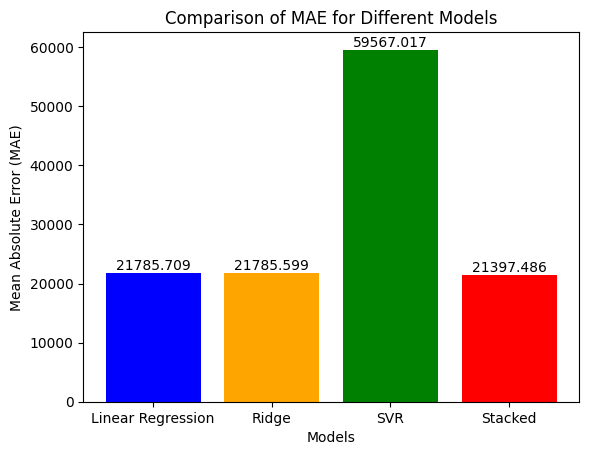

In [265]:
models = ['Linear Regression', 'Ridge', 'SVR', 'Stacked']
mae_values = [mae_lr, mae_ridge, mae_svr, mae_stacked]

fig, ax = plt.subplots()
bars = ax.bar(models, mae_values, color=['blue', 'orange', 'green', 'red'])

ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('Comparison of MAE for Different Models')

# Display MAE values on top of each bar
for bar, mae_value in zip(bars, mae_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(mae_value, 3), ha='center', va='bottom')

plt.show()

Mae stacked results are better than the other 3 models

## Hyperparameter Tuning XGBoost - Optuna

In [266]:
def xgboost_objective(trial):
    params = {
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold()))
    return -score  # Optimize for negative score as Optuna maximizes

In [267]:
study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(xgboost_objective, n_trials=10, n_jobs=-1)

[I 2024-03-10 10:46:34,099] A new study created in memory with name: no-name-8d8ae3fb-3be2-45a9-ac03-8e7647a766fa


[I 2024-03-10 10:46:44,687] Trial 5 finished with value: -0.8611953294385074 and parameters: {'eta': 0.5, 'learning_rate': 0.02, 'n_estimators': 494, 'max_depth': 3}. Best is trial 5 with value: -0.8611953294385074.
[I 2024-03-10 10:46:47,637] Trial 1 finished with value: -0.8611228174614298 and parameters: {'eta': 0.8, 'learning_rate': 0.016, 'n_estimators': 611, 'max_depth': 3}. Best is trial 5 with value: -0.8611953294385074.
[I 2024-03-10 10:46:51,512] Trial 7 finished with value: -0.8625819679584138 and parameters: {'eta': 0.3, 'learning_rate': 0.016, 'n_estimators': 740, 'max_depth': 3}. Best is trial 7 with value: -0.8625819679584138.
[I 2024-03-10 10:46:52,078] Trial 6 finished with value: -0.8616634410332094 and parameters: {'eta': 0.4, 'learning_rate': 0.018, 'n_estimators': 633, 'max_depth': 4}. Best is trial 7 with value: -0.8625819679584138.
[I 2024-03-10 10:46:54,472] Trial 4 finished with value: -0.8622022194106398 and parameters: {'eta': 0.6, 'learning_rate': 0.018, 'n_

In [268]:
best_xgboost_params = study_xgboost.best_params
best_xgboost_model = xgb.XGBRegressor(**best_xgboost_params)
best_xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.016, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=740,
             n_jobs=None, num_parallel_tree=None, ...)

In [269]:
y_train_pred_xgboost = best_xgboost_model.predict(X_train)
y_test_pred_xgboost = best_xgboost_model.predict(X_test)

print("Best XGBoost Model Hyperparameters:", best_xgboost_params)
print("\nMetrics for XGBoost Model:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_xgboost))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_xgboost))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_xgboost))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_xgboost))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_xgboost)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_xgboost)))

Best XGBoost Model Hyperparameters: {'eta': 0.3, 'learning_rate': 0.016, 'n_estimators': 740, 'max_depth': 3}

Metrics for XGBoost Model:
Train MSE: 186913846.74141887
Test MSE: 679454305.386408
Train MAE: 9716.909236542166
Test MAE: 16630.623367936645
Train RMSE: 13671.643893161454
Test RMSE: 26066.344304225095


In [271]:
mae_xgboost = (mean_absolute_error(y_test, y_test_pred_xgboost))

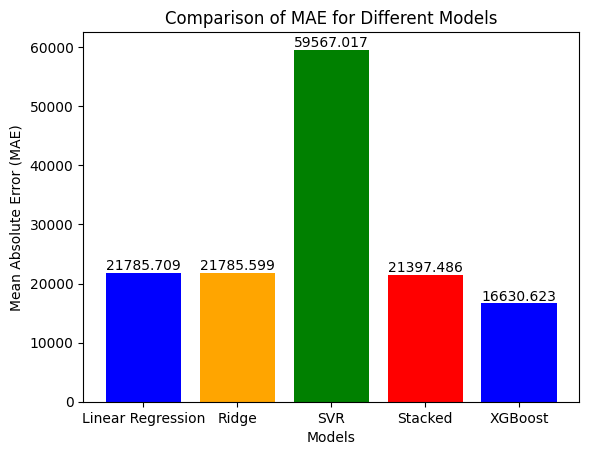

In [272]:
models = ['Linear Regression', 'Ridge', 'SVR', 'Stacked', 'XGBoost']
mae_values = [mae_lr, mae_ridge, mae_svr, mae_stacked, mae_xgboost]

fig, ax = plt.subplots()
bars = ax.bar(models, mae_values, color=['blue', 'orange', 'green', 'red'])

ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('Comparison of MAE for Different Models')

# Display MAE values on top of each bar
for bar, mae_value in zip(bars, mae_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(mae_value, 3), ha='center', va='bottom')

plt.show()

Mae xgboost results are better than the other 4 models